# Separating planetary reflex Doppler shifts from stellar variability in the wavelength domain

Copyright (C) 2021  Prof Andrew Collier Cameron, University of St Andrews

This notebook generates all figures published in Collier Cameron et al 2021, http://arxiv.org/abs/2011.00018 

The dataset on which it operates is contained in the pickle file 
'CCFdata_daily_15min.pkl' which may be accessed at 
https://doi.org/10.17630/9ec51274-cbea-445f-b188-112f4734c6e9 .

To run this notebook ...
Install an up-to-date version python3 (version 3.7 or later), e.g., https://www.anaconda.com/distribution/

The notebook uses routines from the numpy, matplotlib, and pickle packages.

It also uses function definitions from the scalpels_public.py and pyBGLS.py packages supplied with this notebook.

# Compatibility

2-Sep-2020: This notebook has been tested standalone with a fresh installation of anaconda3.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Imports

In [2]:
import numpy as np
import scipy.optimize as opt
import pickle

### Import tools from pyBGLS.py, scalpels_public.py

In [3]:

# Load BGLS
from pyBGLS import bglsconst, bglsgrid, bglsfreq, gls

# Load SCALPELS
from scalpels_public import acf2d,median_abs_dev,goodflag,vscalpels_loocv,vscalpels_recover_loocv
from scalpels_public import getvel_matrix, getvel_matrix_quad,bary2hel,covdiag,covtrgl,getweights,inject
from scalpels_public import sinefit,parabfit,find_extrema,loocv,rearrange_uloocv,mask_outliers,quality_control

### Load the CCF and RV timeseries from the pickled dataset of daily 15-minute HARPS-N solar observations.

In [4]:
period = np.array([])
starname = 'CCFdata_daily_15min'
filename = starname+'.pkl'

with open(filename,'rb') as ccfile:
    ccfpkl,errpkl,badpkl,bjdpkl,rvbpkl,rvhpkl,rvepkl,bervpkl,sn60pkl,qualpkl,vcorpkl,btohpkl,vel = pickle.load(ccfile)

nrow = len(bjdpkl)
print('There are %4.0i data points' %nrow)

savedir = starname+'/'
print(savedir)

There are  886 data points
CCFdata_daily_15min/


Normalise the CCF array and display at full time resolution.

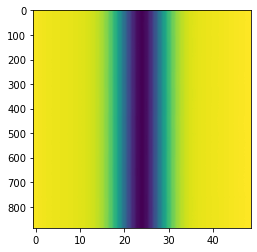

In [5]:
nrow,nvel = np.shape(ccfpkl)
ccfpkl = (ccfpkl.T/np.median(ccfpkl,axis=1)).T
errpkl = (errpkl.T/np.median(ccfpkl,axis=1)).T
plt.imshow(ccfpkl,aspect=nvel/nrow)

Text(0, 0.5, 'Normalized CCF')

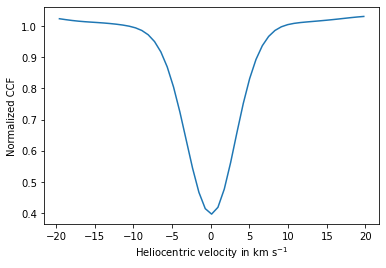

In [6]:
plt.plot(vel,np.median(ccfpkl,axis=0))
plt.xlabel(r'Heliocentric velocity in km s$^{-1}$')
plt.ylabel(r'Normalized CCF')

### Change array names to match stellar version

In [7]:
ccfStar = ccfpkl
errStar = errpkl
bjdList = bjdpkl
rvbList = rvbpkl
rveList = rvepkl
bervList = bervpkl
sn60List = sn60pkl
btohList = btohpkl

sn60List = np.mean(ccfpkl/errpkl,axis=1)

In [8]:
nobs,nvel = np.shape(ccfStar)
print('There are ',nobs,' spectra of length ',nvel,' elements.')

There are  886  spectra of length  49  elements.


## Calibrate DRS and  Taylor-series barycentric velocities against JPL Horizons

First define physical velocity increment PIXstep per instrumental pixel, and sampling increment CCFstep per CCF pixel.

In [9]:
PIXstep = 0.82
CCFstep = (np.max(vel)-np.min(vel))/(len(vel)-1)
print(CCFstep)

0.82


Set k_covsep

In [10]:
k_covsep = 10
if CCFstep == 0.82:
    k_covsep = 5

Compute first-derivative velocities (linear) assuming unit scaling.

In [11]:
velmatBary,vermatBary,vsymatBary = getvel_matrix(vel,ccfpkl,errpkl,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=1.0,empirical=False)

Compute second-derivative velocities (quadratic) assuming unit scaling.

In [12]:
velqadBary,verqadBary,vsyqadBary = getvel_matrix_quad(vel,ccfpkl,errpkl,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=1.0,empirical=False)

Calibrate the DRS velocities against JPL Horizons

RVB (JPL) = RVB(DRS)/0.998081


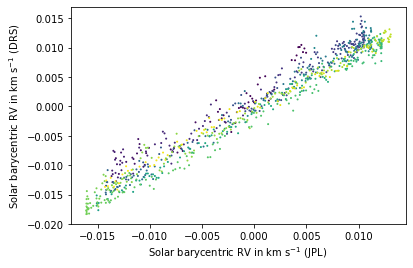

In [13]:
pp = -btohpkl + np.mean(btohpkl)
xx = rvbpkl-np.mean(rvbpkl)
plt.scatter(pp,xx,s=1,c=bjdpkl)
plt.xlabel('Solar barycentric RV in km s$^{-1}$ (JPL) ')
plt.ylabel('Solar barycentric RV in km s$^{-1}$ (DRS) ')
aadrs = np.dot(xx,pp)/np.dot(pp,pp)
print('RVB (JPL) = RVB(DRS)/%8.6f'%aadrs)

For the injection tests later in the script, where we use first-derivative velocities, we also need the scale factor between the first-derivative velocities and the JPL model. Calculate first-derivative velocities from the raw (barycentric) CCFs.

RVB (JPL) = RVB(Taylor1)/1.015153


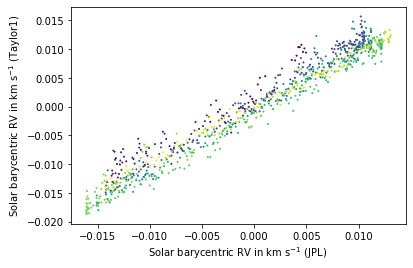

In [14]:
pp = -btohpkl + np.mean(btohpkl)
xx = velmatBary - np.mean(velmatBary)
plt.scatter(pp,xx,s=1,c=bjdpkl)
plt.xlabel('Solar barycentric RV in km s$^{-1}$ (JPL) ')
plt.ylabel('Solar barycentric RV in km s$^{-1}$ (Taylor1) ')
aamat = np.dot(xx,pp)/np.dot(pp,pp)
print('RVB (JPL) = RVB(Taylor1)/%8.6f'%aamat)

RVB (JPL) = RVB(Taylor2)/1.014920


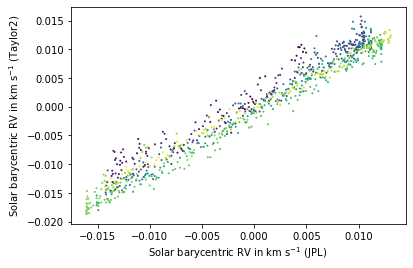

In [15]:
pp = -btohpkl + np.mean(btohpkl)
xx = velqadBary - np.mean(velqadBary)
plt.scatter(pp,xx,s=1,c=bjdpkl)
plt.xlabel('Solar barycentric RV in km s$^{-1}$ (JPL) ')
plt.ylabel('Solar barycentric RV in km s$^{-1}$ (Taylor2) ')
aaqad = np.dot(xx,pp)/np.dot(pp,pp)
print('RVB (JPL) = RVB(Taylor2)/%8.6f'%aaqad)

Scale the barycentric velocities to match the JPL scale, and convert to heliocentric frame.

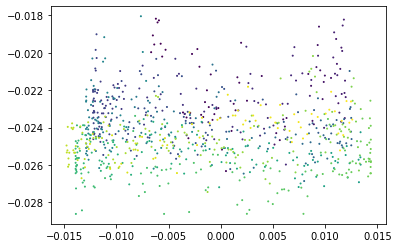

In [16]:
rvbList = rvbpkl/aadrs
rvhList = rvbList + btohpkl
rvcList = rvhList
plt.scatter(btohpkl,rvhList,s=1,c=bjdList)

### Validate CCF shift algorithm

Compute heliocentric CCF, and recompute first-derivative velocities from ccfBary and ccfHel applying JPL scale factor aamat during both CCF shifting and RV measurement. VelmatHel is derived from ccfHel. VelmatHel2 is derived from ccfBary yielding barycentric RVs which are then corrected by subtracting the solar heliocentric motion from the JPL ephemeris.

In [17]:
ccfBary = ccfStar
errbary = errStar
# Shift to heliocentric frame
ccfHel = bary2hel(ccfBary, btohpkl, cdelt1=CCFstep,frac=aamat)
errHel = errStar
# Measure RV from heliocentric CCFs
velmatHel,vermatHel,vsymatHel = getvel_matrix(vel,ccfHel,errHel,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=aamat,empirical=False)
# Measure RV from heliocentric CCFs
velmatBary,vermatBary,vsymatBary = getvel_matrix(vel,ccfBary,errHel,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=aamat,empirical=False)
# Apply heliocentric correction
velmatHel2 = velmatBary + btohpkl

In [18]:
len(velmatHel),len(velmatBary),len(velmatHel2)

(886, 886, 886)

0.04424685618715492

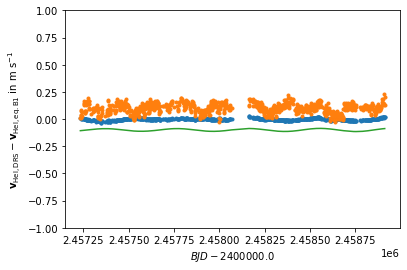

In [19]:
plt.plot(bjdList,1000*(velmatHel2-mean(velmatHel2)-velmatHel),'.')
plt.plot(bjdList,1000*(rvhList-mean(rvhList)-velmatHel)+.1,'.')
plt.plot(bjdList,btohList-.1)
plt.ylabel(r'$\mathbf{v}_{\rm Hel,DRS}-\mathbf{v}_{\rm Hel, eq.B1}$ in m s$^{-1}$')
plt.xlabel(r'$BJD-2400000.0$')
ylim(-1,1)
np.std(rvhList-mean(rvhList)-velmatHel)*1000

RMS velocity scatter = 0.00813 m s$^{-1}$


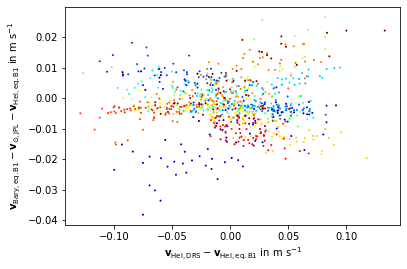

In [20]:
plt.scatter(1000*(rvhList-mean(rvhList)-velmatHel),1000*(velmatHel2-mean(velmatHel2)-velmatHel),s=1,c=bjdList,cmap='jet')
plt.xlabel(r'$\mathbf{v}_{\rm Hel,DRS}-\mathbf{v}_{\rm Hel, eq.B1}$ in m s$^{-1}$')
plt.ylabel(r'$\mathbf{v}_{\rm Bary, eq.B1}-\mathbf{v}_{\odot,\rm{JPL}}-\mathbf{v}_{\rm Hel, eq.B1}$ in m s$^{-1}$')
rmsdiff = np.std((velmatHel2-mean(velmatHel2)-velmatHel)*1000)
print('RMS velocity scatter = %7.5f m s$^{-1}$'%rmsdiff)

This demonstrates that shifting the CCF to the heliocentric frame and measuring first-derivative velocities produces the same results as measuring barycentric velocities from the unshifted CCF and applying the JPL correction, with RMS scatter 8 mm/sec (Paper Section 2.1).

### Compare the pipeline velocities with the Taylor-series ones.

In [21]:
max(btohpkl),min(btohpkl)

(0.014387593386111562, -0.014784675388758453)

The standard deviation of the Taylor-series velocities is 1.809 m s$^{-1}$.


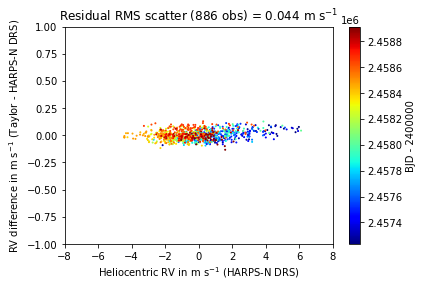

In [22]:
plt.scatter((rvhList-np.mean(rvhList))*1000,(velmatHel-rvhList+np.mean(rvhList))*1000,s=1,c=bjdList,cmap='jet')
#plt.scatter((rvharray-np.mean(rvharray))*1000,(velmatHel)*1000,s=1,c=bjd,cmap='jet')

plt.colorbar(label="BJD - 2400000")
rmsdiff = np.std(velmatHel-rvhList)*1000
plt.title(r'Residual RMS scatter (%3.0i obs) = %5.3f m s$^{-1}$' %(len(rvhList),rmsdiff))
plt.xlabel(r'Heliocentric RV in m s$^{-1}$ (HARPS-N DRS)')
plt.ylabel(r'RV difference in m s$^{-1}$ (Taylor - HARPS-N DRS)')
rmsHel = np.std(velmatHel)*1000
xlim(-8,8)
ylim(-1,1)
plt.savefig(savedir+'vel_matrix.pdf')

print(r'The standard deviation of the Taylor-series velocities is %5.3f m s$^{-1}$.' %rmsHel)

This demonstrates that shifting the CCF to the heliocentric frame and measuring first-derivative velocities produces the same results as applying the JPL correction to the DRS velocities, with RMS scatter 4.4 cm/sec.

In [23]:
len(rvhList),len(velmatHel)

(886, 886)

### Apply VSCALPELS

Don't sort columns of U initially.

In [24]:
ccfNorm = ccfBary

In [25]:
# Un-comment to use the acf of the heliocentric timeseries.
# ccfNorm = ccfHel

##### Outlier clipping

The shape of the CCF is sensitive to more than just solar activity. Changes in focus can affect the FWHM of the CCF, while cryostat warm-ups perturb the skewness of the profile. Noisy CCFs, saturated exposures, or undetected obscuration of part of the solar disc, can also cause temporary profile distortions which may not correlate with any of the most significant principal components. 

Such anomalous observations may indeed generate their own basis functions when SVD is applied to the ACF time-series. Their coefficients are normally close to zero, except when an anomaly occurs. They then appear as outliers in the corresponding columns of $\mathbf{U}_A$. Such pixels can be masked as bad (0) if their absolute deviations lie further from the median value of the column than a specified number of median absolute deviations (MAD), and good (1) otherwise. The product of the column masks then yields a one-dimensional rejection mask in the time domain. For the solar data we found that clipping at 5 times the MAD provided a stable set of basis vectors at the cost of reducing the total number of days of observation from 929 to 841. 

This clipping procedure ensures a clean set of basis vectors, but does not detect outliers caused by anomalous velocity shifts, such as might be caused by an anomalous drift measurement. If present, these must be identified and clipped separately.

Using  49  principal components (kmax = 49).
834


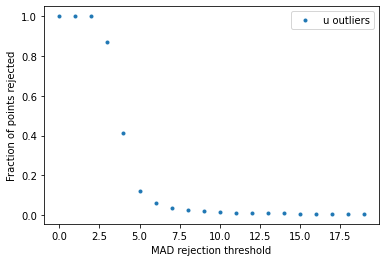

In [26]:
uc = 6
mf = 6

rowmask,badfrac = mask_outliers(ccfNorm,rvcList,rveList,uclip_threshold=uc)

plt.plot(badfrac,'.',label='u outliers')

plt.xlabel('MAD rejection threshold')
plt.ylabel('Fraction of points rejected')

plt.legend()
#plt.semilogy(badfrac1/badfrac0,'.')
#plt.title(starname)
#plt.savefig(savedir+'MADrejection.pdf')
plt.savefig(savedir+'MADrejection.pdf')
print(len(bjdList[rowmask]))

### Determine optimal SVD rank using Leave-One-Out cross-validation (LOOCV)

Start by doing LOOCV on full dataset. Set rank $k$ conservatively to $k=\min(N_{\rm obs}-1,N_{\rm vel})$.

Holding out each row $A_j$ of the ACF in turn, we decompose the remaining rows and compute the singular-value decomposition:
$$
A_{i\ne j}= \mathbf{U}_{i\ne j}\cdot{\rm Diag}({S}_{i\ne j})\cdot{V}_{i\ne j}.
$$
We reconstruct an estimate of the missing $j$th row of $\hat{\mathbf{U}}$ by fitting the eigenvectors and eigenvalues to the $j$th row of the ACF: 
$$
\hat{\mathbf{U}}_j = \frac{(\mathbf{A}_j\cdot{V}^T_{i\ne j})}{({\rm Diag}({S}_{i\ne j})\cdot{V}_{i\ne j})\cdot{V}^T_{i\ne j}}.
$$

We find that the reconstruction of the $k$th column $\hat{\mathbf{U}}^T_k$ reproduces $\mathbf{U}^T_k$ with good fidelity for $k<10$ or so. The ratio of the
median absolute deviation (MAD) of $\mathbf{U}^T_k-\hat{\mathbf{U}}^T_k$ to ${\rm MAD}(\hat{\mathbf{U}}^T_k)$ rises to values close to unity for values of $k>k_{\rm crit}$ for which the leave-one-out cross-validation indicates that the reconstruction is poor.



Determine $k_{\rm opt}$ and plot madfrac.

In [45]:
rowmask.shape
np.save('rowmask', rowmask)

Using  49  principal components (kmax = 49).
Using  49  principal components (kmax = 49).


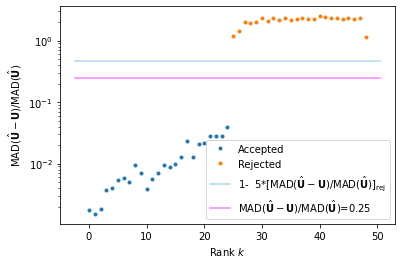

In [27]:

mf = 5
kopt, madratio, badfrac, rowmask = quality_control(ccfNorm,rvcList,rveList,madfac=mf,uclip_threshold=uc)
ycut = 1 - mf * median_abs_dev(madratio[kopt+1:])

fig,ax=plt.subplots()
kval = range(len(madratio))
plt.semilogy(kval[:kopt],madratio[:kopt],'.',label='Accepted')
plt.semilogy(kval[kopt:],madratio[kopt:],'.',label='Rejected')
plt.xlabel(r'Rank $k$')
plt.ylabel(r'MAD($\hat\mathbf{U}-\mathbf{U}$)/MAD($\hat\mathbf{U}$)')
xline = ax.get_xlim()
yline = (ycut,ycut)
plt.semilogy(xline,yline,color='lightblue',label=r'1-%3.0i*[MAD($\hat\mathbf{U}-\mathbf{U}$)/MAD($\hat\mathbf{U}$)]$_{\rm rej}$'%mf)
plt.semilogy(xline,(.25,.25),color='magenta',alpha=0.5,label=r'MAD($\hat\mathbf{U}-\mathbf{U}$)/MAD($\hat\mathbf{U}$)=0.25')
#plt.title(starname)
plt.legend()
#plt.savefig(savedir+'LOOCV.pdf')
plt.savefig(savedir+'LOOCV.pdf')

Display cleaned residual timeseries.

In [28]:
np.array(ccfNorm)[rowmask].shape
badfrac

array([1.        , 1.        , 1.        , 0.87020316, 0.41083521,
       0.12302483, 0.05869074, 0.03724605, 0.02370203, 0.01805869,
       0.01467269, 0.01241535, 0.01128668, 0.01015801, 0.01015801,
       0.00677201, 0.00564334, 0.00564334, 0.00564334, 0.00564334])

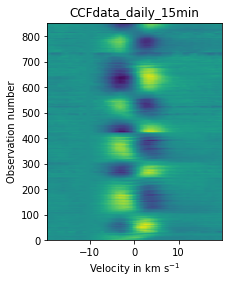

In [29]:
ccf2d = np.array(ccfNorm)[rowmask]
err2d = np.array(errStar)[rowmask]
bjd = np.array(bjdList)[rowmask] - 2400000.0
rvc = np.array(rvcList)[rowmask]/aadrs
rve = np.array(rveList)[rowmask]/aadrs
sn60 = np.array(sn60List)[rowmask]
bsrv = np.array(btohList)[rowmask]

nobs,nvel=np.shape(ccf2d)

left = vel[0]
right = vel[nvel-1]
bottom = 0
top = len(bjd)

imshow(ccf2d-np.mean(ccf2d,axis=0),origin='lower',aspect=nvel/nobs,extent=(left,right,bottom,top))
plt.xlabel(r'Velocity in km s$^{-1}$')
plt.ylabel(r'Observation number')
plt.title(starname)
plt.savefig(savedir+'CCFResid.pdf')
show()
close()

# Optimal $\chi^2$ sorting

Initialize sorting arrays.

In [30]:
print('k_opt = ', kopt)

k_opt =  25


In [31]:
jit = .0011

velmatHel,
rvorth,rvshape,rvclean,uloocv,alploo = vscalpels_loocv(ccf2d,rvc,rve,npc=kopt,sort=False)
# Compute chisq vs k for S ordering
chss=[]
ua = alploo* uloocv
for k in range(kopt+1):
    rvshape = np.sum(ua.T[:k],axis=0)
    chss.append(np.sum((rvorth-rvshape)**2/(rve**2 + jit**2)))

kmax = np.argmin(chss)
print('kmax = ',kmax)

Using  25  principal components (kmax = 25).
kmax =  17


Re-sort columns of $\hat{\mathbf{U}}$ and $\mathbf{\alpha}$ in order of descending $\chi^2(\mathbf{v}_{\perp,k})$.

In [32]:
rvorth,rvshape,rvclean,uloocv,alploo = vscalpels_loocv(ccf2d,rvc,rve,npc=kopt,sort=True,jit=.001)
# Compute chisq vs k for S ordering
chsort=[]
ua = alploo* uloocv
for k in range(kopt+1):
    rvshape = np.sum(ua.T[:k],axis=0)
    chsort.append(np.sum((rvorth-rvshape)**2/(rve**2 + jit**2)))

kmax = np.argmin(chsort)
print('kmax = ',kmax)

Using  13  principal components (kmax = 12).
kmax =  13


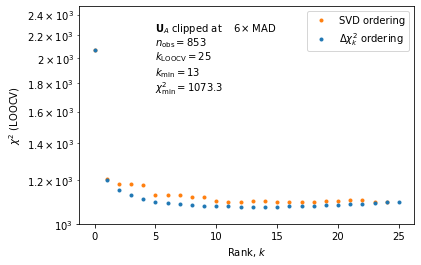

In [33]:
#plt.plot(chss[1:],'.',label=r'SVD ordering',color='C1') 
plt.semilogy(chss[1:],'.',label=r'SVD ordering',color='C1') 

#plt.plot(chsort,'.',label=r'$\Delta\chi^2_k$ ordering',color='C0') 
plt.semilogy(chsort,'.',label=r'$\Delta\chi^2_k$ ordering',color='C0') 


chsmax = np.max(chss)
chsortmax = np.max(chsort)
ymax = np.max([chsmax,chsortmax]) * 1.2
plt.plot()
plt.xlabel(r'Rank, $k$')
plt.ylabel(r'$\chi^2$ (LOOCV)')
ylim(1000,ymax)
plt.legend()
plt.text(0.2*kopt,0.9*ymax,r'$\mathbf{U}_A$ clipped at %4.0i$\times$ MAD' % uc)
plt.text(0.2*kopt,0.85*ymax,r'$n_{\rm obs} = %4.0i$' % len(ccf2d))
plt.text(0.2*kopt,0.8*ymax,r'$k_{\rm LOOCV} = %4.0i$' % kopt);
plt.text(0.2*kopt,0.75*ymax,r'$k_{\rm min} = %4.0i$' % kmax);
plt.text(0.2*kopt,0.7*ymax,r'$\chi^2_{\rm min} = %6.1f$' % chsort[kmax]);

plt.savefig(savedir+'rankchisq.pdf')

Using  13  principal components (kmax = 12).


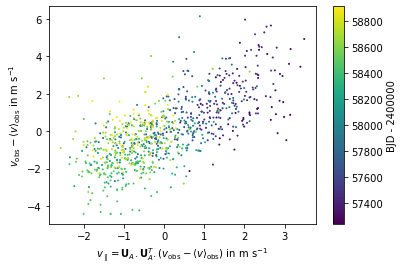

In [34]:
rvorth,rvshape,rvclean,uloocv,alploo = vscalpels_loocv(ccf2d,rvc,rve,npc=kopt,sort=True,jit=.001)

rvcleanm=rvclean*1000
rvshapem=rvshape*1000
rvorthm=rvorth*1000

fig=plt.figure()
#plt.gca().set_aspect('equal', adjustable='box')
#plt.plot((-8,8),(-8,8),c='lightblue')
plt.scatter(rvshapem,rvorthm,s=1,c=bjd)
plt.ylabel(r'$v_{\rm obs}-\left<v\right>_{\rm obs}$ in m s$^{-1}$')
plt.xlabel(r'$v_\parallel=\mathbf{U}_A.\mathbf{U}_A^T.(v_{\rm obs}-\left<v\right>_{\rm obs})$ in m s$^{-1}$')
#plt.xlim(-8,8)
#plt.ylim(-8,8)
plt.colorbar(label='BJD - 2400000')
#plt.title(starname)
plt.savefig(savedir+'rv_correlation.pdf',bbox_inches='tight')

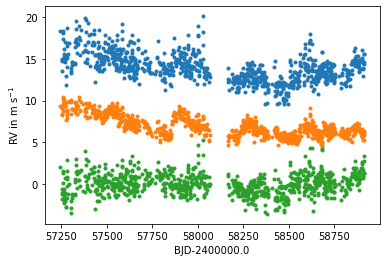

In [35]:
offset = 4*np.std(rvorthm)
plt.plot(bjd,rvorthm+2*offset,'.')
plt.plot(bjd,rvshapem+offset,'.')
plt.plot(bjd,rvcleanm,'.')
plt.xlabel(r'BJD-2400000.0')
plt.ylabel(r'RV in m s$^{-1}$')
#plt.title(starname)
plt.savefig(savedir+'RVplot.pdf',bbox_inches = 'tight');

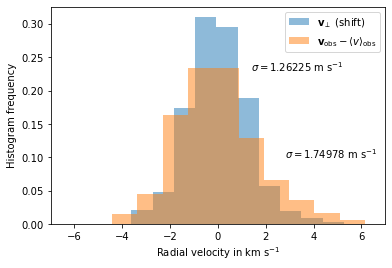

In [36]:
plt.hist(rvcleanm,10,density = True,alpha=0.5,label=r'$\mathbf{v}_\perp$ (shift)');
plt.hist(rvorthm,10,density = True,alpha=0.5,label=r'$\mathbf{v}_{\rm obs}-\left<v\right>_{\rm obs}$');
plt.legend()
plt.xlim(-4*np.std(rvorthm),4*np.std(rvorthm))
axes = plt.gca()
yrange = axes.get_ylim()
xrange = axes.get_xlim()
plt.text(xrange[0]+0.6*(xrange[1]-xrange[0]),0.7*yrange[1],r'$\sigma = %6.5f$ m s$^{-1}$' %np.std(rvcleanm))
plt.text(xrange[0]+0.7*(xrange[1]-xrange[0]),0.3*yrange[1],r'$\sigma = %6.5f$ m s$^{-1}$' %np.std(rvorthm))
plt.xlabel(r'Radial velocity in km s$^{-1}$')
plt.ylabel(r'Histogram frequency')
#plt.title(starname)
plt.savefig(savedir+'histHel.pdf',bbox_inches = 'tight');

# Radial-velocity response to ACF time-domain variations

### Plot the highest-variance velocity projections and their (B)GLS periodograms

This was requested by the referee: 

*Parallel to Figure 6, I’d like to see the periodograms of these. I think those are somehow related to the periodograms you show in your results, so they should appear here before you get to those results. I bet there are consistent features across all plots.*


Need to format it nicely. First compute the arrays to be plotted.

In [37]:
# User input: set period search range
pmin = 1.2
pmax = 500.0
fs = 1/pmax
fe = 1/pmin
df = 1/(max(bjd)-min(bjd))/16
nn = (fe-fs)/df
farray = fs + (fe-fs)*arange(nn)/nn
Parray = 1/farray

In [38]:
jit = 0.0
e = np.sqrt(rve**2 + jit**2)
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
Kamp2d = []
powr2d = []
Kerr2d = []
logl2d = []
UAvel = []
for k in range(kmax+1):
    data = ua[:,k]
    d = data - np.dot(w,data)/np.dot(w,unit)
    W, Y, YYh = bglsconst(t,d,e)
    Kamp = []
    powr = []
    Kerr = []
    logl = []
    for f in farray:
        result = gls(t, d, rve, f, W, Y)
        Kamp.append(result[0])
        powr.append(result[1])
        Kerr.append(result[2])
        logl.append(bglsfreq(t, d, rve, f, W, Y))
    Kamp2d.append(Kamp)
    powr2d.append(powr)
    Kerr2d.append(Kerr)
    logl2d.append(logl)
    UAvel.append(d)

<Figure size 432x288 with 0 Axes>

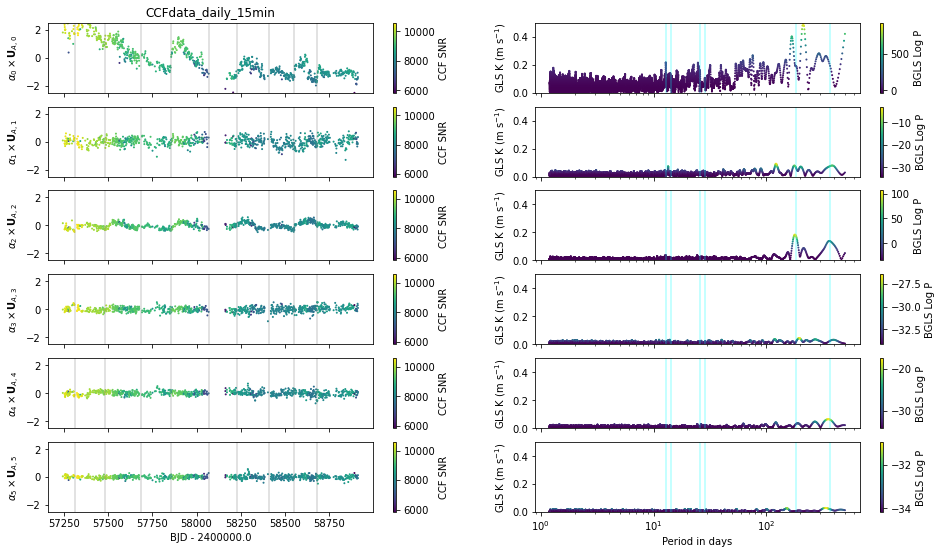

In [39]:
plt.figure()
kplt = min(kmax,6)
fig,ax = plt.subplots(kplt,2,figsize=(16,9),sharex='col')
ax[0,0].set_title(starname)

warmups = np.array([57308.5, 57478.5, 57687.5, 57854.5, 58071.5,58231.5, 58412.5, 58554.5, 58684.5,58839.5
                    #,58997.5
                   ])
phi = 28.5
x0,y0 = (phi,phi),(0,10000)
x1,y1 = (phi/2,phi/2),(0,10000)
plo = 26.0
x2,y2 = (plo,plo),(0,10000)
x3,y3 = (plo/2,plo/2),(0,10000)
pyr = 365.25
x4,y4 = (pyr,pyr),(0,10000)
x5,y5 = (pyr/2,pyr/2),(0,10000)

for k in range(kplt):
    UAvelm = (UAvel[k]+0.)*1000
    for i in range(len(warmups)-1):
        ax[k,0].axvline(warmups[i],c='gray',alpha=.3)
    
    im0=ax[k,0].scatter(bjd,UAvelm,s=1,c=sn60)#,cmap='jet')
    ax[k,0].set_ylim(-2.5,2.5)
#    ax[k,0].set_ylabel(r'$\alpha_{%2.0i}\times \mathbf{U}_{A,%2.0i}$ (m s$^{-1}$)' %(k,k))
    ax[k,0].set_ylabel(r'$\alpha_{%2.0i}\times \mathbf{U}_{A,%2.0i}$' %(k,k))
    Kampm = (np.array(Kamp2d[k])+0.)*1000
    ax[k,1].axvline(phi,c='cyan',alpha=.3)
    ax[k,1].axvline(plo,c='cyan',alpha=.3)
    ax[k,1].axvline(phi/2,c='cyan',alpha=.3)
    ax[k,1].axvline(plo/2,c='cyan',alpha=.3)
    ax[k,1].axvline(pyr,c='cyan',alpha=.3)
    ax[k,1].axvline(pyr/2,c='cyan',alpha=.3)
    ax[k,1].set_xscale('log')
    #ax[k,1].set_ylabel('GLS K in m s$^{-1}$')
    ax[k,1].set_ylabel('GLS K (m s$^{-1}$)')
    im1=ax[k,1].scatter(Parray,Kampm,s=1,c=logl2d[k])#,cmap='jet')
    ax[k,1].set_ylim(0,.5)
    fig.colorbar(im1,ax=ax[k,1],label='BGLS Log P')
    fig.colorbar(im0,ax=ax[k,0],label=r'CCF SNR')
    

ax[k,0].set_xlabel('BJD - 2400000.0')
ax[k,1].set_xlabel('Period in days')
plt.savefig(savedir+'RVproj.pdf',bbox_inches = 'tight');
show()
close()

### Plot the covariance matrix of the barycentric CCF timeseries

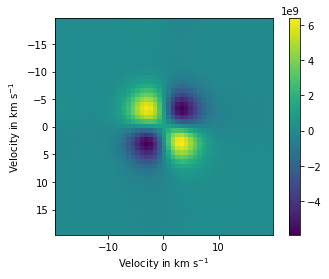

Maximum variance along diagonal =  6425888300.0


In [40]:
ccfRes = ccf2d - np.mean(ccf2d,axis=0)
# Scale CCFs by SN60:
ccfScal = (ccf2d.T*sn60*sn60).T
#ccfScal = ccf2d
uu,ss,vv = np.linalg.svd(ccfScal,full_matrices=False)
k=8
covar = np.dot(vv[1:k].T,np.dot(diag(ss[1:k]*ss[1:k]),vv[1:k]))/len(ccfRes)

nvel = len(vel)
left = vel[0]
right = vel[nvel-1]
bottom = -vel[0]
top = -vel[nvel-1]

imshow(covar,extent=(left,right,bottom,top))
colorbar()

xlabel(r'Velocity in km s$^{-1}$')
ylabel(r'Velocity in km s$^{-1}$')

savefig(savedir+'covmat_ccf2d_rank9.pdf')
show()
close()
print('Maximum variance along diagonal = ',max(diag(covar)))

Plot the principal components of the shape-driven RV signal and their amplitude periodograms.

# Figure 1: Illustrate CCF and ACF in barycentric and heliocentric frame.

Time sequence of residual solar CCFs and the ACFs of the CCFs, spanning the period from 2015 July to 2018 December. 
Each row represents one day of observation. 
Days on which no data were obtained are not shown, so although time increases up the vertical axis, the time scale is not linear. The barycentric residual CCF (upper left) shows the solar reflex motion about the solar system barycentre. Dominated by Jupiter, it has an amplitude of 12 m~s$^{-1}$ and Jupiter's synodic period of 398 days. The residual CCF in the heliocentric frame (lower left) shows a secular change in line depth, deepening as the solar activity level declines over the period of observation.

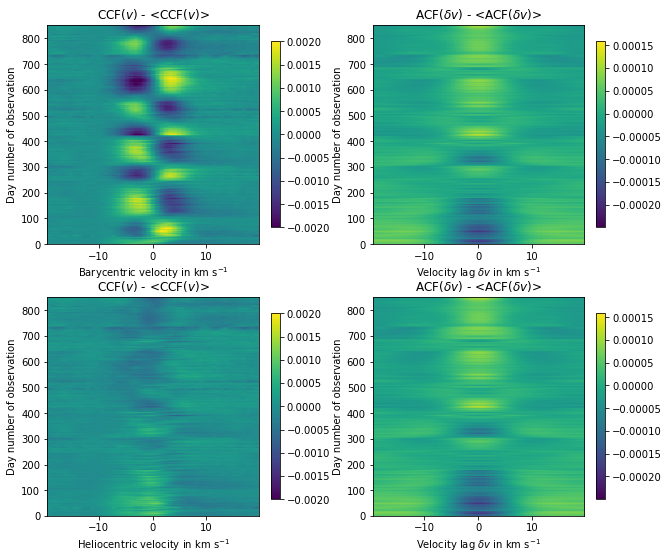

853 57242.03269943828 58913.98322201241


In [41]:
ccfBary = ccf2d
#bjd = bjdarray
#bsrv = btoharray

nspec, nvel = np.shape(ccfBary)
#SVDord = min(nspec,nvel)
ccfAsp = nvel/nspec/1.2

acfBary = acf2d(ccfBary)

# Display results
fig, ax = plt.subplots(2,2,figsize=(10,10),gridspec_kw={'wspace':0.4, 'hspace':0})

left,right,bottom,top = min(vel),max(vel),0,len(bjd)

# Compute column-averaged CCF and residuals - barycentric
ccfMean = np.mean(ccfBary,axis=0)
ccfRes = ccfBary - ccfMean

# Compute column-averaged ACF and residuals - barycentric
acfMean = np.mean(acfBary,axis=0)
acfRes = acfBary - acfMean

ccfimb=ax[0,0].imshow(ccfRes,vmin=-.002,vmax=.002,aspect=ccfAsp,extent = (left,right,bottom,top),origin='lower')
ax[0,0].set_xlabel('Barycentric velocity in km s$^{-1}$')
ax[0,0].set_ylabel('Day number of observation')
ax[0,0].set_title('CCF($v$) - <CCF($v$)>')
plt.colorbar(ccfimb,ax=ax[0,0],fraction=0.04, pad=0.05)

acfimb=ax[0,1].imshow(acfRes,aspect=ccfAsp,extent = (left,right,bottom,top),origin='lower')
ax[0,1].set_xlabel('Velocity lag $\delta v$ in km s$^{-1}$')
ax[0,1].set_ylabel('Day number of observation')
ax[0,1].set_title('ACF($\delta v$) - <ACF($\delta v$)>')
plt.colorbar(acfimb,ax=ax[0,1],fraction=0.04, pad=0.05)

# Transform CCF timeseries from barycentric to heliocentric frame
#ccfHel = bary2hel(ccfBary, bsrv, cdelt1=CCFstep, frac=12/12)
ccfHel = bary2hel(ccfBary, bsrv, cdelt1=CCFstep, frac=aamat)
errHel = err2d
acfHel = acf2d(ccfHel)

# Compute column-averaged CCF and residuals - barycentric
ccfMean = mean(ccfHel,axis=0)
ccfRes = ccfHel - ccfMean

# Compute column-averaged ACF and residuals - barycentric
acfMean = mean(acfHel,axis=0)
acfRes = acfHel - acfMean

ccfimh = ax[1,0].imshow(ccfRes,vmin=-.002,vmax=.002,aspect=ccfAsp,extent = (left,right,bottom,top),origin='lower')
ax[1,0].set_xlabel('Heliocentric velocity in km s$^{-1}$')
ax[1,0].set_ylabel('Day number of observation')
ax[1,0].set_title('CCF($v$) - <CCF($v$)>')
plt.colorbar(ccfimh,ax=ax[1,0],fraction=0.04, pad=0.05)

acfimh = ax[1,1].imshow(acfRes,aspect=ccfAsp,extent = (left,right,bottom,top),origin='lower')
ax[1,1].set_xlabel('Velocity lag $\delta v$ in km s$^{-1}$')
ax[1,1].set_ylabel('Day number of observation')
ax[1,1].set_title('ACF($\delta v$) - <ACF($\delta v$)>')
plt.colorbar(acfimh,ax=ax[1,1],fraction=0.04, pad=0.05)
#plt.savefig(savedir+'ccfRes.png')
plt.savefig(savedir+'ccfRes.pdf',bbox_inches='tight')
plt.show()
plt.close()

print(len(ccfHel),bjd[0],bjd[len(ccfHel)-1])

In [54]:
# Display difference image heliocentric-barycentric ACF

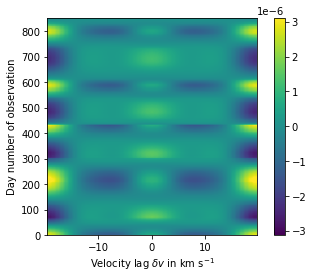

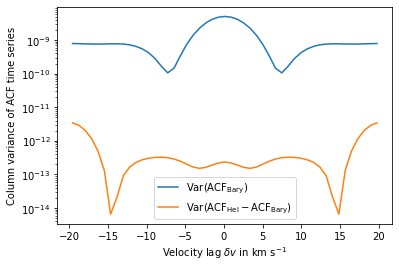

In [55]:
acfDif = acfHel - acfBary
vlo = np.mean(acfDif)-4*np.std(acfDif)
vhi = np.mean(acfDif)+4*np.std(acfDif)
plt.imshow(acfHel-acfBary,aspect=ccfAsp,extent=(left,right,bottom,top),vmin=vlo,vmax=vhi)
plt.xlabel('Velocity lag $\delta v$ in km s$^{-1}$')
plt.ylabel('Day number of observation')
plt.colorbar()
plt.show()
#dfrac = np.array((acfHel-acfBary)/acfBary)
plt.semilogy(vel,np.var(acfBary,axis=0),label=r'${\rm Var}({\rm ACF}_{\rm Bary})$')
plt.semilogy(vel,np.var(acfHel-acfBary,axis=0),label=r'${\rm Var}({\rm ACF}_{\rm Hel}-{\rm ACF}_{\rm Bary})$')
plt.ylabel(r'Column variance of ACF time series')
plt.xlabel(r'Velocity lag $\delta v$ in km s$^{-1}$')
plt.legend()
#plt.ylim(1e-7,1e-5)
plt.savefig(savedir+'acfResDiffVar.pdf',bbox_inches='tight')
show()



# Figure 2: SVD of CCF and ACF

The first four basis vectors of the singular-value decomposition of the CCF (upper left) and the ACF of the CCFs (upper right) of the heliocentric time series. Their coefficients are plotted against barycentric Julian date in the lower panels.  Both the basis vectors and scores have been arbitrarily shifted in the vertical direction for clarity.

In [43]:
ucb,scb,vcb = np.linalg.svd(ccfBary,full_matrices = False)
uab,sab,vab = np.linalg.svd(acfBary,full_matrices = False)
uch,sch,vch = np.linalg.svd(ccfHel,full_matrices = False)
uah,sah,vah = np.linalg.svd(acfHel,full_matrices = False)

uch[:,1] *= -1
vch[1] *= -1
uch[:,2] *= -1
vch[2] *= -1

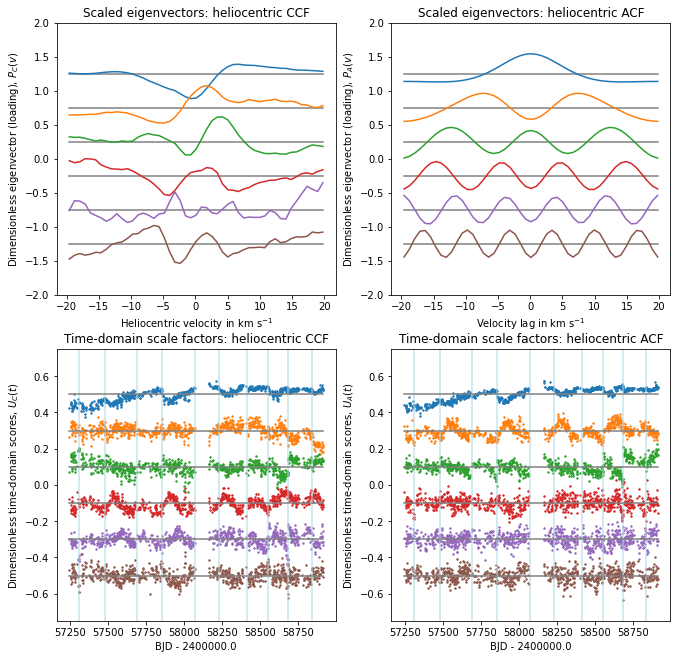

In [44]:
# Display eigenvectors
fig, ax = plt.subplots(2,2,figsize=(11,11))

n = kmax
n = 6

for i in range(n):
    ax[0,0].plot(vel,zeros_like(vel)-0.5*(i-(n-1)/2),color='gray')
    ax[0,0].plot(vel,vch[i+1]-0.5*(i-(n-1)/2),label='Eigenvector %2i'%(i+1))
    ax[0,0].set_xlabel('Heliocentric velocity in km s$^{-1}$')
    ax[0,0].set_ylabel('Dimensionless eigenvector (loading), $P_C(v)$')
    ax[0,0].set_title('Scaled eigenvectors: heliocentric CCF')
    ax[0,0].set_ylim(-2,2)
    #ax[0,0].legend()

for i in range(n):
    ax[0,1].plot(vel,zeros_like(vel)-0.5*(i-(n-1)/2),color='gray')
    ax[0,1].plot(vel,vah[i+1]-0.5*(i-(n-1)/2),label='Eigenvector %2i'%(i+1))
    ax[0,1].set_xlabel('Velocity lag in km s$^{-1}$')
    ax[0,1].set_ylabel('Dimensionless eigenvector (loading), $P_A(v)$')
    ax[0,1].set_title('Scaled eigenvectors: heliocentric ACF')
    ax[0,1].set_ylim(-2,2)
    #ax[0,1].legend()

ymin,ymax = -0.75,0.75
warmups = np.array([57308.5, 57478.5, 57687.5, 57854.5, 58071.5,58231.5, 58412.5, 58554.5, 58684.5, 
                    58839.5, #58997.5
                   ])
yvalmin = ymin*np.ones_like(warmups)
yvalmax = ymax*np.ones_like(warmups)

for i in range(len(warmups)):
    ax[1,0].plot([warmups[i],warmups[i]],[yvalmin[i],yvalmax[i]],color='lightblue',alpha=0.7)
for i in range(n):
    ax[1,0].plot(bjd,zeros_like(bjd)-0.2*(i-(n-1)/2),color='gray')
    ax[1,0].scatter(bjd,uch[:,i+1]-0.2*(i-(n-1)/2),s=2,label='Eigenvector %2i'%(i+1))
    ax[1,0].set_xlabel('BJD - 2400000.0')
    ax[1,0].set_ylabel('Dimensionless time-domain scores, $U_C(t)$')
    ax[1,0].set_title('Time-domain scale factors: heliocentric CCF')
    ax[1,0].set_ylim(ymin,ymax)

for i in range(len(warmups)):
    ax[1,1].plot([warmups[i],warmups[i]],[yvalmin[i],yvalmax[i]],color='lightblue',alpha=0.7)

for i in range(n):
    ax[1,1].plot(bjd,zeros_like(bjd)-0.2*(i-(n-1)/2),color='gray')
    ax[1,1].scatter(bjd,uah[:,i+1]-0.2*(i-(n-1)/2),s=2,label='Eigenvector %2i'%(i+1))
    ax[1,1].set_xlabel('BJD - 2400000.0')
    ax[1,1].set_ylabel('Dimensionless time-domain scores, $U_A(t)$')
    ax[1,1].set_title('Time-domain scale factors: heliocentric ACF')
    ax[1,1].set_ylim(ymin,ymax)
    #ax[2,1].legend()

yvals = np.array([-0.1, -0.1, -0.1, -0.1, -0.1,-0.1, -0.1])
#ax[1,1].plot(warmups,yvals,'o',color='gray')

plt.savefig(savedir+'eigenvectors.pdf',bbox_inches = 'tight')
show()
close()

# Figure 4: BGLS analyses of time-series scale factors

Bayesian Generalised Lomb-Scargle periodograms of the four leading principal components 
of the residual CCF of the heliocentric time series. 
The y-axis is the posterior probability density marginalised over the amplitude, 
phase and zero point of each time series. 
The second principal component, which has no unique counterpart among the principal 
components of the ACF, shows strong power at the solar synodic rotation period 
(denoted by vertical bars at $P=27.0$ day and 28.0 day) and its first harmonic.

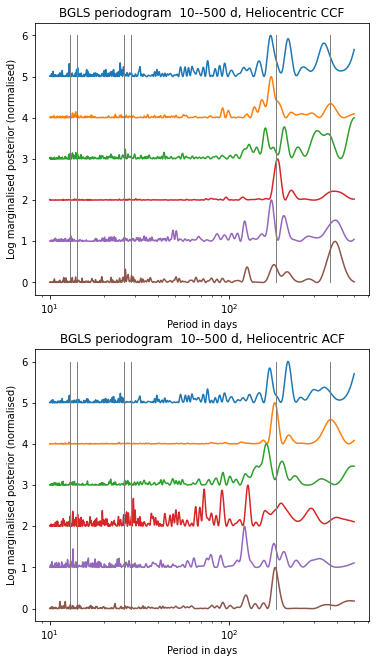

In [45]:
# Load BGLS
sys.path.insert(0, '/Users/acc4/OneDrive - University of St Andrews/CodeDevelopment/PythonTools/pyBGLS/')
from pyBGLS import bglsconst, bglsgrid, bglsfreq

# User input: set period search range
pmin = 10
pmax = 500.0
#pmax = 60.0
fs = 1/pmax
fe = 1/pmin
df = 1/(max(bjd)-min(bjd))/16
nn = (fe-fs)/df
farray = fs + (fe-fs)*arange(nn)/nn
Parray = 1/farray

# Perform a BGLS frequency search

#n=kopt
n=6
# Display BGLS likelihood periodograms normalised to peak value = 1.
fig, ax = plt.subplots(2,1,figsize=(6,11))

phi = 28.5
x0,y0 = (phi,phi),(0,10000)
x1,y1 = (phi/2,phi/2),(0,10000)
plo = 26.0
x2,y2 = (plo,plo),(0,10000)
x3,y3 = (plo/2,plo/2),(0,10000)
pyr = 365.25
x4,y4 = (pyr,pyr),(0,10000)
x5,y5 = (pyr/2,pyr/2),(0,10000)

#ok = bjd < 59000

for i in range(n):
    utemp = np.transpose(uch)[i+1]
    udiff = utemp - np.roll(utemp,-1)
    ustdv = np.std(udiff) / np.sqrt(2) * ones_like(utemp)
    W, Y, YYh = bglsconst(bjd, utemp, ustdv)
    bglslogl = []
    for f in farray:
        bglslogl.append(bglsfreq(bjd, utemp, ustdv, f, W, Y))

    if i==0:
        vscal = 1 # np.max(bglslogl)-np.min(bglslogl)
        y0 = (0,n*vscal)
        y1 = y0
        y2 = y0
        y3 = y0
        y4 = y0
        y5 = y0
    ax[0].semilogx(x0,y0,linewidth=1,color='gray')
    ax[0].semilogx(x1,y1,linewidth=1,color='gray')
    ax[0].semilogx(x2,y2,linewidth=1,color='gray')
    ax[0].semilogx(x3,y3,linewidth=1,color='gray')
    ax[0].semilogx(x4,y4,linewidth=1,color='gray')
    ax[0].semilogx(x5,y5,linewidth=1,color='gray')
    ax[0].semilogx(Parray,(bglslogl-min(bglslogl))/(max(bglslogl)-min(bglslogl))-vscal*(i-(n-1)))
    #ax[0].semilogx(Parray,(bglslogl-np.min(bglslogl))-vscal*(i-(n-1)))
    ax[0].set_xlabel('Period in days')
    ax[0].set_ylabel('Log marginalised posterior (normalised)')
    ax[0].set_title('BGLS periodogram %3i--%3i d, Heliocentric CCF'%(pmin,pmax))

for i in range(n):
    utemp = np.transpose(uah)[i+1]
    udiff = utemp - np.roll(utemp,-1)
    ustdv = np.std(udiff) / np.sqrt(2) * ones_like(utemp)
    W, Y, YYh = bglsconst(bjd, utemp, ustdv)
    bglslogl = []
    for f in farray:
        bglslogl.append(bglsfreq(bjd, utemp, ustdv, f, W, Y))
    
    if i==0:
        vscal = 1 #np.max(bglslogl)-np.min(bglslogl)
        y0 = (0,n*vscal)
        y1 = y0
        y2 = y0
        y3 = y0
        y4 = y0
        y5 = y0
    ax[1].semilogx(x0,y0,linewidth=1,color='gray')
    ax[1].semilogx(x1,y1,linewidth=1,color='gray')
    ax[1].semilogx(x2,y2,linewidth=1,color='gray')
    ax[1].semilogx(x3,y3,linewidth=1,color='gray')
    ax[1].semilogx(x4,y4,linewidth=1,color='gray')
    ax[1].semilogx(x5,y5,linewidth=1,color='gray')
    ax[1].semilogx(Parray,(bglslogl-min(bglslogl))/(max(bglslogl)-min(bglslogl))-vscal*(i-(n-1)))
    #ax[1].semilogx(Parray,(bglslogl-np.min(bglslogl))-vscal*(i-(n-1)))
    ax[1].set_xlabel('Period in days')
    ax[1].set_ylabel('Log marginalised posterior (normalised)')
    ax[1].set_title('BGLS periodogram %3i--%3i d, Heliocentric ACF'%(pmin,pmax))

savefig(savedir+'ccfBGLS.pdf',bbox_inches='tight')
show()
close()

# Figure 6: Covariance matrix for oversampled,time-varying CCFs

First compute the mean-subtracted, heliocentric CCF and compute its covariance matrix using a full SV decomposition.

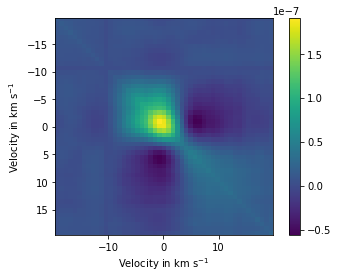

In [46]:
ccfRes = ccfHel - np.mean(ccfHel,axis=0)
uu,ss,vv = np.linalg.svd(ccfRes,full_matrices=False)

nvel = len(vel)
left = vel[0]
right = vel[nvel-1]
bottom = -vel[0]
top = -vel[nvel-1]

covmeas = np.dot(vv.T,np.dot(diag(ss*ss),vv))/len(ccfRes)
imshow(covmeas,extent=(left,right,bottom,top))
colorbar()

xlabel(r'Velocity in km s$^{-1}$')
ylabel(r'Velocity in km s$^{-1}$')

savefig(savedir+'covmeas.pdf')

First determine the optimal rank $k$ that best separates the large-scale covariances due to profile shape changes, from the local correlations between neighbouring pixels in the CCF rows arising from oversampling of the photon noise pattern in the original spectra.

In [47]:
len(covmeas)

49

Optimal rank for covariance pattern separation k =  5


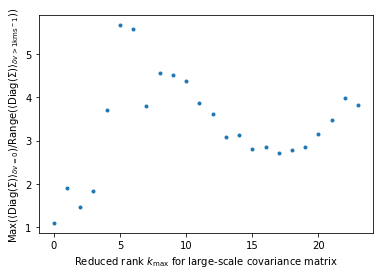

In [48]:
ratlist = []
size = len(covmeas)
halfsize = np.round((size)/2).astype('i')
for k in range(halfsize):
    covar = np.dot(vv[:k].T,np.dot(diag(ss[:k]*ss[:k]),vv[:k]))/len(ccfRes)
    covresid = covmeas - covar
    xsmean=[]
    for koff in np.arange(-halfsize,halfsize):
        sample = np.mean(np.diag(covresid,koff))
        xsmean.append(sample)
    idxpeak = np.where(xsmean==np.max(xsmean))[0].astype('i')[0]
    xsvel = vel[0:size-1]
    mask = np.abs(xsvel) > 1.0
    ratlist.append(xsmean[idxpeak]/(np.max(np.array(xsmean)[mask])-np.min(np.array(xsmean)[mask])))
    
plt.plot(ratlist,'.')
plt.xlabel(r'Reduced rank $k_{\rm max}$ for large-scale covariance matrix')
plt.ylabel(r'${\rm Max}(\left<{\rm Diag}(\Sigma)\right>_{\delta v =0})/{\rm Range}(\left<{\rm Diag}(\Sigma)\right>_{\delta v > 1 {\rm km s}^-1}))$')

k_covsep = np.where(ratlist == np.max(ratlist))[0].astype('i')[0]
print(r'Optimal rank for covariance pattern separation k = %2.0i' %k_covsep)

In [49]:
if CCFstep == 0.82:
    k_covsep = 9

## Large-scale covariance model

There is a clear peak at $k=10$ in the plot above. 

Make a reduced-rank ($k=10$) covariance matrix of the sequence of CCFs residuals, showing the large-scale covariance due to profile variability.

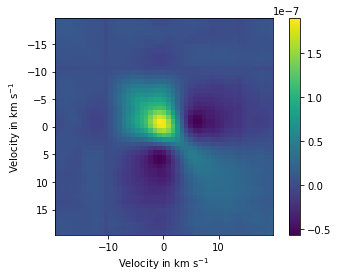

Maximum variance along diagonal =  1.9043141394252562e-07


In [50]:
k = k_covsep+1
covar = np.dot(vv[:k].T,np.dot(diag(ss[:k]*ss[:k]),vv[:k]))/len(ccfRes)

nvel = len(vel)
left = vel[0]
right = vel[nvel-1]
bottom = -vel[0]
top = -vel[nvel-1]

imshow(covar,extent=(left,right,bottom,top))
colorbar()

xlabel(r'Velocity in km s$^{-1}$')
ylabel(r'Velocity in km s$^{-1}$')

savefig(savedir+'covmat_rank%2.0i.pdf' %k_covsep)
show()
close()
print('Maximum variance along diagonal = ',max(diag(covar)))


Residual covariance matrix obtained by subtracting the reduced-rank representation from the full covariance matrix. Recall that partitioning at $k=10$ is the best compromise between an adequate representation of the profile covariance and the small-scale noise covariance shown here.

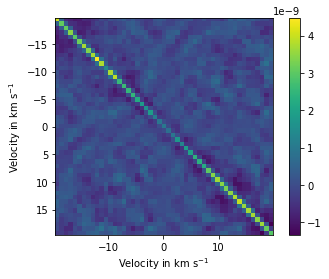

In [51]:
nvel = len(vel)
left = vel[0]
right = vel[nvel-1]
bottom = -vel[0]
top = -vel[nvel-1]

covresid = covmeas - covar
imshow(covresid,extent=(left,right,bottom,top))
colorbar()

xlabel(r'Velocity in km s$^{-1}$')
ylabel(r'Velocity in km s$^{-1}$')

savefig(savedir+'covmat_rank%2.0i_resid.pdf' %k_covsep)
show()
close()


## Correlated photon-noise covariance model

Define a model covariance matrix $\Sigma_j$ for each spectrum with the form of a triangular ridge whose value along the diagonal is the normalised CCF, multiplied by a factor $\beta_j$. The value of $\beta_j$ is determined by subtracting a rank-$k$ model of the CCF series from the data, leaving a set of residuals 
$$
R_j = C_j - ^kC_j
$$
whose covariance matrix is dominated by a diagonal ridge of triangular profile representing random noise with correlations between neighbouring CCF bins.
The likelihood of this fit is 
$$
\log{\mathcal L} = -\frac{1}{2\beta_j}R_j^T\cdot \Sigma^{-1}_j \cdot R_j -\frac{1}{2}\log |\Sigma_j| -\frac{1}{2}\log\beta_j.
$$
$\log{\mathcal L}$ is maximised when 
$$
\beta_j = R_j^T\cdot \Sigma^{-1}_j \cdot R_j.
$$

Mean residual covariance along diagonals as a function of horizontal distance from the leading diagonalof the matrix. The dominant diagonal ridge is triangular in cross-section, with base width 2.3 km s$^{-1}$, which is close to one resolution element of the spectrograph.

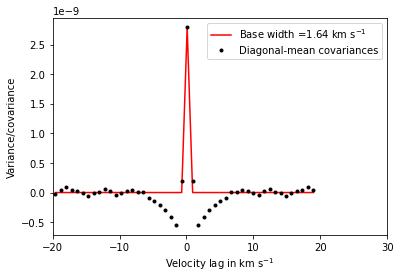

In [52]:
covresid = covmeas - covar
xsmean=[]
for koff in np.arange(-halfsize,halfsize):
    sample = np.mean(np.diag(covresid,koff))
    xsmean.append(sample)
xsvel = vel[50:110]
xsvel = vel[0:size-1]


coeff = np.max(xsmean)
xsv0 = xsvel[np.argmax(xsmean)]
hdvbase = PIXstep
base = hdvbase*2
profile = coeff * np.clip(1 - np.abs(xsvel-xsv0)/hdvbase,0,None)
plot(xsvel,profile,color='r',label='Base width =%4.2f km s$^{-1}$'%base)
plot(xsvel,xsmean,'.',color = 'k',label='Diagonal-mean covariances')
xlabel('Velocity lag in km s$^{-1}$')
ylabel('Variance/covariance')
xlim(-20,30)
legend()
savefig(savedir+'covtrgl_rank%2.0i.pdf' %k_covsep)
show()
close()



In [53]:
CCFstep

0.82

This next bit isn't the full likelihood calculation shown above, but instead uses a rank-reduced reconstruction of the residual CCF time series to get the row variances.

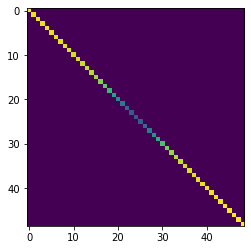

In [54]:
rowvar = errHel[0]*errHel[0]
matrix = covdiag(vel,rowvar)
imshow(np.linalg.inv(matrix))

## Plot correlated photon-noise errors and errors with profile systematics

Calculate velocity errors due to photon noise using empirical CCF noise estimate.

In [55]:
vel_emp,ver_emp,vsy_emp = getvel_matrix(vel,ccfHel,errHel,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=aamat,empirical=True)


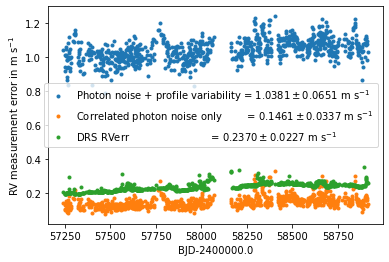

In [56]:
mer = np.mean(ver_emp)*1000
ser = np.std(ver_emp)*1000
msy = np.mean(vsy_emp)*1000
ssy = np.std(vsy_emp)*1000
mdr = np.mean(rve)*1000
sdr = np.std(rve)*1000
plt.plot(bjd,vsy_emp*1000,'.',label=r'Photon noise + profile variability = $%6.4f \pm %6.4f$ m s$^{-1}$'%(msy,ssy))
plt.plot(bjd,ver_emp*1000,'.',label='Correlated photon noise only        = $%6.4f \pm %6.4f$ m s$^{-1}$'%(mer,ser))
plt.plot(bjd,rve*1000,'.',    label=r'DRS RVerr                          = $%6.4f \pm %6.4f$ m s$^{-1}$'%(mdr,sdr))
plt.xlabel('BJD-2400000.0')
plt.ylabel('RV measurement error in m s$^{-1}$')
plt.legend()

Calculate velocity errors due to photon noise using DRS CCF noise estimate.

In [57]:
vel_err,ver_err,vsy_err = getvel_matrix(vel,ccfHel,errHel,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=aamat,empirical=False)

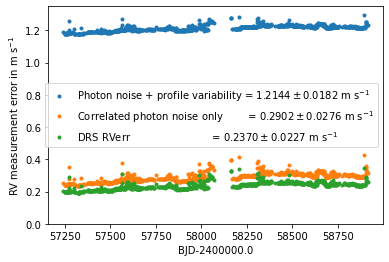

In [58]:
mer = np.mean(ver_err)*1000
ser = np.std(ver_err)*1000
msy = np.mean(vsy_err)*1000
ssy = np.std(vsy_err)*1000
mdr = np.mean(rve)*1000
sdr = np.std(rve)*1000
plt.plot(bjd,vsy_err*1000,'.',label=r'Photon noise + profile variability = $%6.4f \pm %6.4f$ m s$^{-1}$'%(msy,ssy))
plt.plot(bjd,ver_err*1000,'.',label='Correlated photon noise only        = $%6.4f \pm %6.4f$ m s$^{-1}$'%(mer,ser))
plt.plot(bjd,rve*1000,'.',    label=r'DRS RVerr                          = $%6.4f \pm %6.4f$ m s$^{-1}$'%(mdr,sdr))
plt.xlabel('BJD-2400000.0')
plt.ylabel('RV measurement error in m s$^{-1}$')
plt.ylim(0,)
plt.legend()

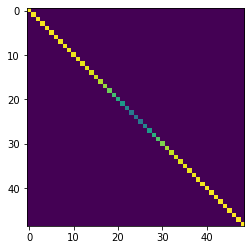

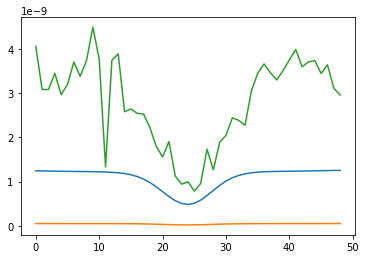

In [59]:
k = k_covsep+1
ccfWeight = getweights(ccfHel,npc=k)
row = 350
rowvar = 1/(ccfWeight[row])      
testmatrix = covtrgl(vel,ccfHel[row],rowvar)
imshow(testmatrix)
show()
plt.plot(np.diag(testmatrix*rowvar))
plt.plot(np.diag(testmatrix)/sn60[row]**2/250)
plt.plot(np.diag(covresid))

## Leave-one-out cross-validation

To determine the optimal number of basis vectors, we perform leave-one-out cross-validation. 

For the $j$th data point we perform SVD using all rows $i\ne j$ of the ACF time series, to derive a 
training set of scores $\mathbf{U}_{i\ne j}$, eigenvalues $\mathbf{S}_{i\ne j}$ and eigenvectors $\mathbf{V}_{i\ne j}$ from all observations except the one being modelled. The projection coefficients $\mathbf{\alpha}_j$ for the $j$th observation are computed from $\mathbf{U}_{i\ne j}$ and the mean-subtracted RVs omitting the $j$th observation:
$$
\mathbf{\alpha}_j = (\mathbf{v}_{\rm obs} - \left<v_{\rm obs}\right>)_{i\ne j}\cdot \mathbf{U}_{i\ne j}.
$$

We estimate the scores for the $j$th observation 
$$
\mathbf{\hat{U}}_j = \frac{\mathbf{A}_j\cdot\mathbf{V}^T_{i\ne j}}{(\mathbf{S}_{i\ne j}\cdot\mathbf{V}_{i\ne j})\cdot\mathbf{V}^T_{i\ne j}}
$$
using the observed ACF $\mathbf{A}_j$. The shape-driven velocity is then calculated independently of the training set as
$$
v_{\parallel,j} = \mathbf{\alpha}_j\cdot\mathbf{\hat{U}}_j.
$$

Now we've found $k_{\rm opt}$, clean the observed RVs using the heliocentric CCFs without Jupiter's signal, using $k_{\rm opt}$ principal components.

Recompute everything from masked arrays

In [60]:
ccfBary = ccfStar[rowmask]
errbary = errStar[rowmask]
# Shift to heliocentric frame
ccfHel = bary2hel(ccfBary, btohpkl[rowmask], cdelt1=CCFstep,frac=aamat)
errHel = errStar[rowmask]
# Measure RV from heliocentric CCFs
velmatHel,vermatHel,vsymatHel = getvel_matrix(vel,ccfHel,errHel,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=aamat,empirical=False)
# Measure RV from heliocentric CCFs
velmatBary,vermatBary,vsymatBary = getvel_matrix(vel,ccfBary,errHel,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=aamat,empirical=False)
# Apply heliocentric correction

In [61]:

vorthHel,vshapeHel,vcleanHel,uloocv,alploo = vscalpels_loocv(ccfHel,velmatHel,vsymatHel,npc=kopt,sort=True)

Using  12  principal components (kmax = 11).


Plot the correlation of the observed velocities $\mathbf{v}_{\rm obs}-\left<v_{\rm obs}\right>$ against the SCALPELS model of $\mathbf{v}_\parallel$.

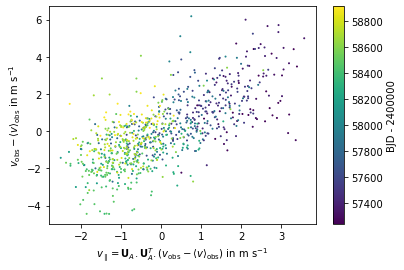

In [62]:
plt.scatter(vshapeHel*1000,vorthHel*1000,s=1,c=bjd)
plt.ylabel(r'$v_{\rm obs}-\left<v\right>_{\rm obs}$ in m s$^{-1}$')
plt.xlabel(r'$v_\parallel=\mathbf{U}_A.\mathbf{U}_A^T.(v_{\rm obs}-\left<v\right>_{\rm obs})$ in m s$^{-1}$')
plt.colorbar(label='BJD - 2400000')
plt.savefig(savedir+'rv_correlation.pdf',bbox_inches='tight')

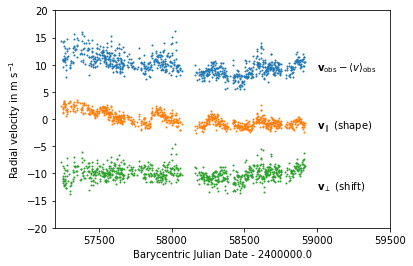

In [63]:
plt.scatter(bjd,1000*vorthHel+10,s=1)    
plt.scatter(bjd,1000*vshapeHel,s=1)  
plt.scatter(bjd,1000*vcleanHel-10,s=1) 
plt.xlabel(r'Barycentric Julian Date - 2400000.0')
plt.ylabel(r'Radial velocity in m s$^{-1}$')

plt.text(59000,9,r'$\mathbf{v}_{\rm obs}-\left<v\right>_{\rm obs}$')
plt.text(59000,-2,r'$\mathbf{v}_\parallel$ (shape)')
plt.text(59000,-13,r'$\mathbf{v}_\perp$ (shift)')

plt.ylim(-20,20)
plt.xlim(57200,59500)

plt.savefig(savedir+'velHel.pdf',bbox_inches = 'tight')


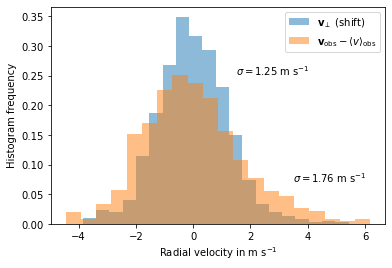

In [64]:
blue = 1000*vcleanHel
orange = 1000*vorthHel
plt.hist(blue,20,density = True,alpha=0.5,label=r'$\mathbf{v}_\perp$ (shift)');
plt.hist(orange,20,density = True,alpha=0.5,label=r'$\mathbf{v}_{\rm obs}-\left<v\right>_{\rm obs}$');
plt.legend()
plt.text(3.5,0.070,r'$\sigma = %4.2f$ m s$^{-1}$' %np.std(vorthHel*1000))
plt.text(1.5,0.250,r'$\sigma = %4.2f$ m s$^{-1}$' %np.std(vcleanHel*1000))
plt.xlabel(r'Radial velocity in m s$^{-1}$')
plt.ylabel(r'Histogram frequency')
plt.savefig(savedir+'histHel.pdf',bbox_inches = 'tight');

# Amplitude periodograms

In [65]:
# User input: set period search range
pmin = 1.2
pmax = 500.0
fs = 1/pmax
fe = 1/pmin
df = 1/(max(bjd)-min(bjd))/16
nn = (fe-fs)/df
farray = fs + (fe-fs)*arange(nn)/nn
Parray = 1/farray

In [66]:
jit = 0.0
KHel = []
powrHel = []
KerrHel = []
loglHel = []
data = vorthHel
e = np.sqrt(rve**2 + jit**2)
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t, d,e)
for f in farray:
    result = gls(t, d, rve, f, W, Y)
    KHel.append(result[0])
    powrHel.append(result[1])
    KerrHel.append(result[2])
    loglHel.append(bglsfreq(t, d, rve, f, W, Y))
    
KModel = []
powrModel = []
KerrModel = []
loglModel = []
data = vshapeHel
e = np.sqrt(rve**2 + jit**2)
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t,d,e)
for f in farray:
    result = gls(t, d, rve, f, W, Y)
    KModel.append(result[0])
    powrModel.append(result[1])
    KerrModel.append(result[2])
    loglModel.append(bglsfreq(t, d, rve, f, W, Y))

KShift = []
powrShift = []
KerrShift = []
loglShift = []
data = vcleanHel
e = np.sqrt(rve**2 + jit**2)
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t, d,e)
for f in farray:
    result = gls(t, d, rve, f, W, Y)
    KShift.append(result[0])
    powrShift.append(result[1])
    KerrShift.append(result[2])
    loglShift.append(bglsfreq(t, d, rve, f, W, Y))

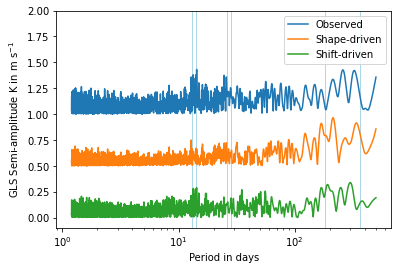

In [67]:
offset = 0.0005

#plt.figure(figsize=(10,6))
phi = 28.5
plo = 26.0
pyr = 365.25
plines = [plo/2,phi/2,plo,phi,pyr/2,pyr]
for ip in range(len(plines)):
    #x,y = (period[ip],period[ip]),(0,4*offset*1000)
    #semilogx(x,y,linewidth=1,color='lightblue')
    plt.axvline(plines[ip],linewidth=1,color='lightblue')


semilogx(Parray,(np.array(KHel)+2*offset)*1000,label='Observed')
semilogx(Parray,(np.array(KModel)+offset)*1000,label='Shape-driven')
semilogx(Parray,(np.array(KShift)+0)*1000,label='Shift-driven')
xlabel('Period in days')
ylabel('GLS Semi-amplitude K in m s$^{-1}$')
ylim(-.1,4000*offset)
legend(loc='upper right')
#plt.title(starname)
plt.savefig(savedir+'periodogram_amp_000cms.pdf',bbox_inches = 'tight')
show()
close()

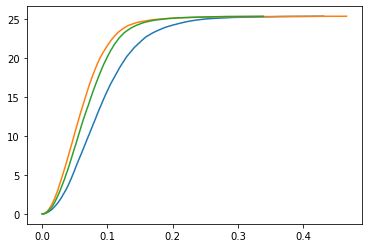

In [68]:
plot(1000*np.array(KHel)[np.argsort(np.array(KHel))],np.arange(len(KHel))/878)
plot(1000*np.array(KModel)[np.argsort(np.array(KModel))],np.arange(len(KModel))/878)
plot(1000*np.array(KShift)[np.argsort(np.array(KShift))],np.arange(len(KShift))/878)

Text(0, 0.5, 'Frequency histogram and cumulative distribution')

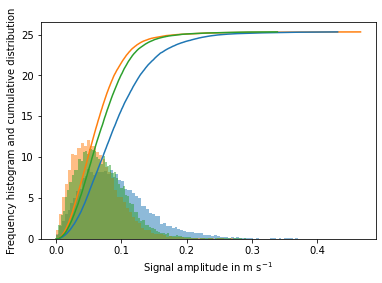

In [69]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.hist(np.array(KHel)*1000,density=True,alpha=0.5,bins=100);
plt.hist(np.array(KModel)*1000,density=True,alpha=0.5,bins=100);
plt.hist(np.array(KShift)*1000,density=True,alpha=0.5,bins=100);

plot(1000*np.array(KModel)[np.argsort(np.array(KModel))],np.arange(len(KModel))/878,color=colors[1])
plot(1000*np.array(KHel)[np.argsort(np.array(KHel))],np.arange(len(KHel))/878,color=colors[0])
plot(1000*np.array(KShift)[np.argsort(np.array(KShift))],np.arange(len(KShift))/878,color=colors[2])

plt.xlabel(r'Signal amplitude in m s$^{-1}$')
plt.ylabel(r'Frequency histogram and cumulative distribution')

In [70]:
np.max(KShift)

0.0003386518013972264

In [71]:
array = find_extrema(farray,KHel,thresh=.00030)
for rec in array:   
    frequencies = rec[0]
    periods = 1/frequencies
    amplitudes = rec[1]*1000
    print('%6.5f & %6.3f & %5.3f'%(frequencies,periods,amplitudes))
    

0.00308 & 324.861 & 0.422
0.00386 & 259.352 & 0.427
0.00469 & 213.015 & 0.336
0.01776 & 56.303 & 0.315
0.03879 & 25.779 & 0.359
0.04060 & 24.630 & 0.375
0.06690 & 14.947 & 0.302
0.06985 & 14.316 & 0.431
0.07074 & 14.136 & 0.379
0.07173 & 13.941 & 0.350
0.07481 & 13.368 & 0.380
0.07798 & 12.825 & 0.359


In [72]:
array = find_extrema(farray,KShift,thresh=.00030)
for rec in array:   
    frequencies = rec[0]
    periods = 1/frequencies
    amplitudes = rec[1]*1000
    print('%6.5f & %6.3f & %5.3f'%(frequencies,periods,amplitudes))
    

0.00333 & 300.453 & 0.339
0.00522 & 191.469 & 0.320


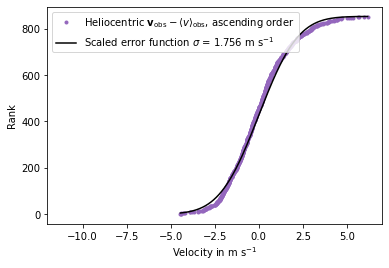

In [73]:
from scipy.special import erf
vH = (vorthHel)*1000
z=np.linspace(np.min(vH),np.max(vH),1000)/std(vH)
plot(vH[np.argsort(vH)],np.arange(len(vH)),'.',color='C4',label = r'Heliocentric $\mathbf{v}_{\rm obs}-\left<v\right>_{\rm obs}$, ascending order')
plot(z*std(vH),1/2*(1 + erf(z/np.sqrt(2)))*len(vH),label = r'Scaled error function $\sigma$ = %5.3f m s$^{-1}$'%std(vH),color='k')
legend(loc='upper left')
xlabel(r'Velocity in m s$^{-1}$')
ylabel(r'Rank')
xlim(-12,7)
savefig(savedir+'gaussHel.pdf',bbox_inches='tight')
show()
close()




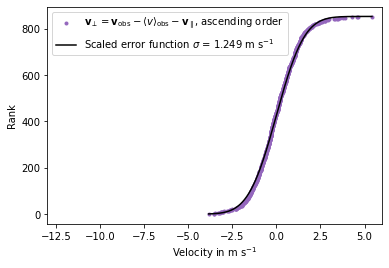

In [74]:
from scipy.special import erf
vH = (vcleanHel)*1000
z=np.linspace(np.min(vH),np.max(vH),1000)/std(vH)
plot(vH[np.argsort(vH)],np.arange(len(vH)),'.',color='C4',label = r'$\mathbf{v}_\perp=\mathbf{v}_{\rm obs}-\left<v\right>_{\rm obs}-\mathbf{v}_\parallel$, ascending order')
plot(z*std(vH),1/2*(1 + erf(z/np.sqrt(2)))*len(vH),label = r'Scaled error function $\sigma$ = %5.3f m s$^{-1}$'%std(vH),color='k')
legend(loc='upper left')
xlabel(r'Velocity in m s$^{-1}$')
ylabel(r'Rank')
xlim(-13,6)
savefig(savedir+'gaussShift.pdf',bbox_inches='tight')
show()
close()




In [75]:
from scipy.stats import anderson
anderson(vcleanHel,dist='norm')

AndersonResult(statistic=1.0119065878335505, critical_values=array([0.573, 0.653, 0.783, 0.914, 1.087]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

<ipython-input-76-cd0956f63c57>:23: RuntimeWarning: invalid value encountered in log
  vgrid[ijd] = np.log(-1)
<ipython-input-76-cd0956f63c57>:24: RuntimeWarning: invalid value encountered in log
  vgrido[ijd] = np.log(-1)
<ipython-input-76-cd0956f63c57>:25: RuntimeWarning: invalid value encountered in log
  vgrids[ijd] = np.log(-1)


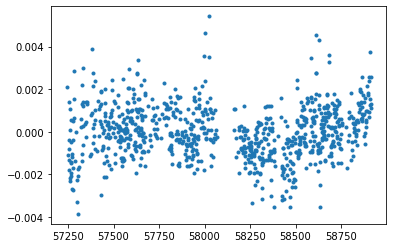

In [76]:
from statsmodels.tsa.stattools import acf
#gapmethod='none'
#gapmethod='raise'
gapmethod='conservative'
#gapmethod='drop'



bjds = np.round(bjd[0])
bjde = np.round(bjd[len(bjd)-1])
jdgrid = np.arange(bjds,bjde+1,1)
jdgrid[0],bjds,jdgrid[len(jdgrid)-1],bjde
vgrid = jdgrid*0
vgrido = jdgrid*0
vgrids = jdgrid*0
for ijd in range(len(jdgrid)):
    idx = np.where(np.abs(jdgrid[ijd]-bjd) < 0.5)
    if len(idx[0]) == 1:
        vgrid[ijd] = vcleanHel[idx[0]]
        vgrido[ijd] = vorthHel[idx[0]]
        vgrids[ijd] = vshapeHel[idx[0]]
    else:
        vgrid[ijd] = np.log(-1)
        vgrido[ijd] = np.log(-1)
        vgrids[ijd] = np.log(-1)
        
plot(jdgrid,vgrid,'.')

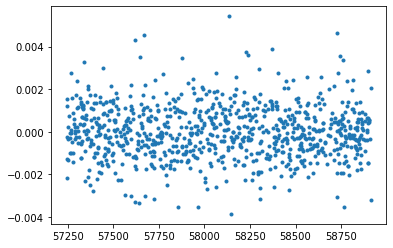

In [77]:
rnd = np.random.normal(0,1,len(vgrid))
idx = np.argsort(rnd)
vgridt = vgrid[idx]
plot(jdgrid,vgridt,'.')

Use statsmodels.tsa.stattools.acf to check independence of measurements.
autostat[0] is the ACF
autostat[1] is the Ljung-Box Q-statistic
autostat[2] is the array of p-values associated with Q

In statistical hypothesis testing, the p-value or probability value is, for a given statistical model, the probability that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two groups) would be equal to, or more extreme than, the actual observed results.

In this case, Ljung-Box indicates a probability less than 1% that we'd have got these results by chance if they were generated by a process that is uncorrelated at each of the lags < 28 days that are considered. The correlation is weakest at lags between  5 and 12 days, and strongest around the solar rotation period.

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


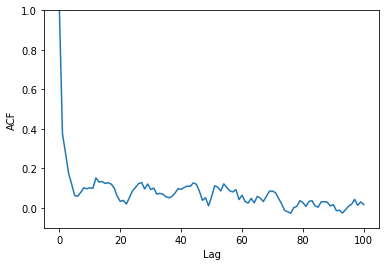

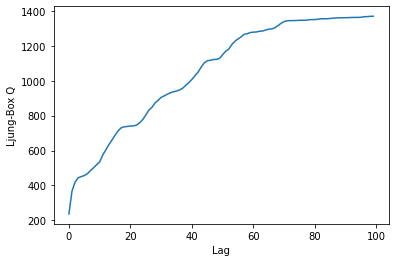

<ipython-input-78-6170b395322e>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ylim(0,1)


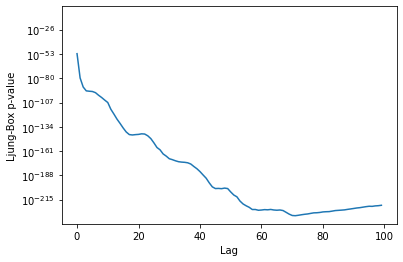

In [78]:
resid = vgrid - np.mean(vcleanHel)
autostat = acf(resid,missing=gapmethod,qstat=True,nlags = 100)
acfclean = autostat[0]
plot(autostat[0])
ylim(-0.1,1)
xlabel('Lag')
ylabel('ACF')
show()
# Plot the p-values associated with the Ljung-Box Q-statistic.
plot(autostat[1])
xlabel('Lag')
ylabel('Ljung-Box Q')
show()
semilogy(autostat[2])
ylim(0,1)
xlabel('Lag')
ylabel('Ljung-Box p-value')
show()

Repeat for the original data.

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


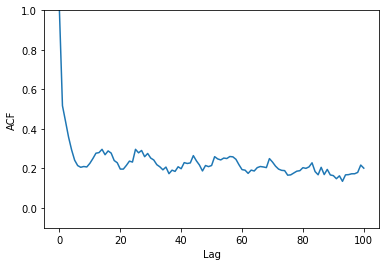

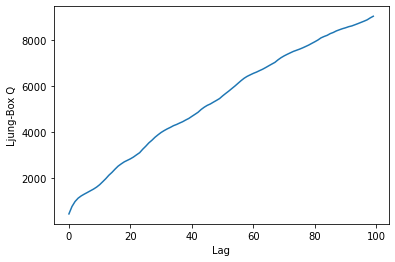

<ipython-input-79-7834629b941e>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ylim(0,1)


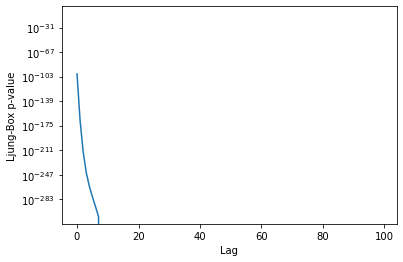

In [79]:
resid = vgrido - np.mean(vorthHel)
autostat = acf(resid,missing=gapmethod,qstat=True,nlags = 100)
acforth = autostat[0]
plot(autostat[0])
ylim(-0.1,1)
xlabel('Lag')
ylabel('ACF')
show()
# Plot the p-values associated with the Ljung-Box Q-statistic.
plot(autostat[1])
xlabel('Lag')
ylabel('Ljung-Box Q')
show()
semilogy(autostat[2])
ylim(0,1)
xlabel('Lag')
ylabel('Ljung-Box p-value')
show()

Repeat for the shape data

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


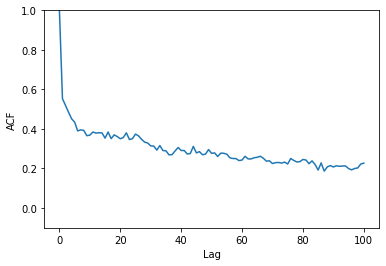

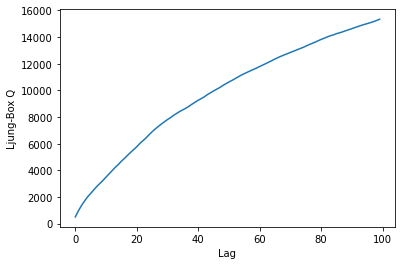

<ipython-input-80-ec1699e10bb7>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ylim(0,1)


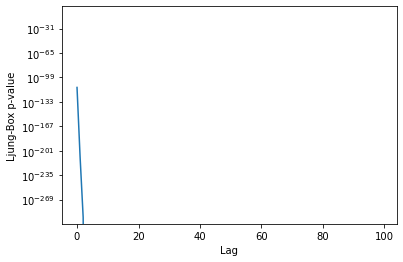

In [80]:
resid = vgrids - np.mean(vshapeHel)
autostat = acf(resid,missing=gapmethod,qstat=True,nlags = 100)
acfshape = autostat[0]
plot(autostat[0])
ylim(-0.1,1)
xlabel('Lag')
ylabel('ACF')
show()
# Plot the p-values associated with the Ljung-Box Q-statistic.
plot(autostat[1])
xlabel('Lag')
ylabel('Ljung-Box Q')
show()
semilogy(autostat[2])
ylim(0,1)
xlabel('Lag')
ylabel('Ljung-Box p-value')
show()

Now try it on a series of random gaussian numbers. We see much larger p values, meaning it's more probable that we'd have got the data if the hypothesis that the data are uncorrelated is true.

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


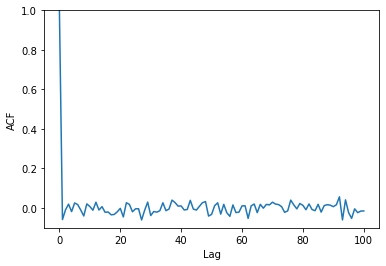

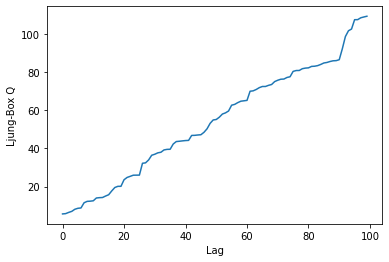

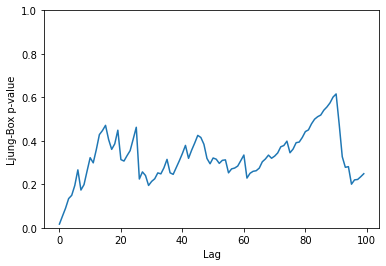

In [81]:
#testdata = np.random.normal(0,1,10000)
#autotest = acf(testdata,missing='drop',qstat=True)
#acftest = autotest[0]

resid = vgridt - np.mean(vcleanHel)
autotest = acf(resid,missing=gapmethod,qstat=True,nlags = 100)
acftest = autotest[0]

plot(autotest[0])
ylim(-0.1,1)
xlabel('Lag')
ylabel('ACF')
show()
# Plot the p-values associated with the Ljung-Box Q-statistic.
plot(autotest[1])
xlabel('Lag')
ylabel('Ljung-Box Q')
show()
plot(autotest[2])
ylim(0,1)
xlabel('Lag')
ylabel('Ljung-Box p-value')
show()

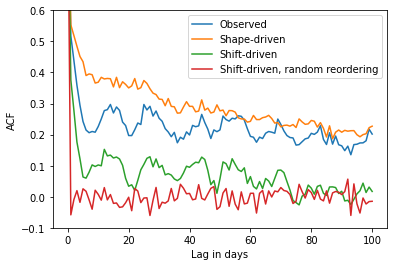

In [82]:
plt.plot(acforth,label='Observed')
plt.plot(acfshape,label='Shape-driven')
plt.plot(acfclean,label='Shift-driven')
plt.plot(acftest,label='Shift-driven, random reordering')
ylim(-0.1,0.6)
xlabel('Lag in days')
ylabel('ACF')
legend()
savefig(savedir+'serialACFs.pdf',bbox_inches = 'tight')



# Injection tests

Use getvel_matrix to measure velocities. Use the covariance matrix of the raw CCF for extracting velocities from the raw data, and the covariance matrix of the cleaned CCF for extracting velocities from the cleaned CCF.

In [83]:
ampcms = 40.0
ampkms = ampcms / 10**5
# Start with the heliocentric timeseries and inject a small signal.
T0 = np.mean(bjd)
P0 = 7.14159
K0 = ampkms
ccfNew = inject(ccfHel, bjd, T0, P0, K0, inject=True, cdelt1=CCFstep)

T1 = np.mean(bjd)+3.2
P1 = 27.12345
K1 = ampkms
ccfNew = inject(ccfNew, bjd, T1, P1, K1, inject=True, cdelt1=CCFstep)

T2 = np.mean(bjd)+18.3
P2 = 101.54321
K2 = ampkms
ccfNew = inject(ccfNew, bjd, T2, P2, K2, inject=True, cdelt1=CCFstep)

T3 = np.mean(bjd)+13.8
P3 = 213.59265
K3 = ampkms
ccfNew = inject(ccfNew, bjd, T3, P3, K3, inject=True, cdelt1=CCFstep)



In [84]:
# Measure Taylor-series velocities from CCF with injected planet shifts.

velmatNew,vermatNew,vsymatNew = getvel_matrix(vel,ccfNew,errHel,hdvbase=PIXstep,cdelt1=CCFstep,k=k_covsep+1,sc=aamat,empirical=False)
vorthNew,vshapeNew,vcleanNew,alploo,uloocv = vscalpels_loocv(ccfNew,velmatNew,vsymatNew,npc=kopt,sort=True)

Using  13  principal components (kmax = 12).


In [85]:
jit = 0.0
KNew = []
powrNew = []
KerrNew = []
loglNew = []
data = vorthNew
e = np.sqrt(rve**2 + jit**2)
e = vsymatNew
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t, d,e)
for f in farray:
    result = gls(t, d, e, f, W, Y)
    KNew.append(result[0])
    powrNew.append(result[1])
    KerrNew.append(result[2])
    loglNew.append(bglsfreq(t, d, rve, f, W, Y))
    
KModel = []
powrModel = []
KerrModel = []
loglModel = []
data = vshapeNew
e = np.sqrt(rve**2 + jit**2)
e = vsymatNew
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t,d,e)
for f in farray:
    result = gls(t, d, e, f, W, Y)
    KModel.append(result[0])
    powrModel.append(result[1])
    KerrModel.append(result[2])
    loglModel.append(bglsfreq(t, d, e, f, W, Y))

KShift = []
powrShift = []
KerrShift = []
loglShift = []
data = vcleanNew
e = np.sqrt(rve**2 + jit**2)
e = vsymatNew
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t, d,e)
for f in farray:
    result = gls(t, d, e, f, W, Y)
    KShift.append(result[0])
    powrShift.append(result[1])
    KerrShift.append(result[2])
    loglShift.append(bglsfreq(t, d, e, f, W, Y))

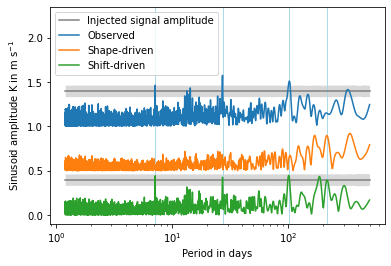

In [86]:


offset = 0.0005
period = [P0,P1,P2,P3]

for P in period:
    plt.axvline(P,linewidth=1,color='lightblue')

up = (np.array(KShift)*0+ampcms/100000+np.array(KerrNew))*1000
dn = (np.array(KShift)*0+ampcms/100000-np.array(KerrNew))*1000
plt.fill_between(Parray,up+2*1000*offset,dn+2*1000*offset,color='gray',lw=0,alpha=0.3)
semilogx([pmin,pmax],[ampcms/100+2*1000*offset,ampcms/100+2*1000*offset],'gray',label='Injected signal amplitude')

up = (np.array(KShift)*0+ampcms/100000+np.array(KerrShift))*1000
dn = (np.array(KShift)*0+ampcms/100000-np.array(KerrShift))*1000
plt.fill_between(Parray,up,dn,color='gray',lw=0,alpha=0.3)
semilogx([pmin,pmax],[ampcms/100,ampcms/100],'gray')

semilogx(Parray,(np.array(KNew)+2*offset)*1000,label='Observed')

semilogx(Parray,(np.array(KModel)+offset)*1000,label='Shape-driven')

semilogx(Parray,(np.array(KShift)+0)*1000,label='Shift-driven')


#plt.scatter(Parray,(np.array(KShift))*1000,s=1,c=bglsNew)
#plt.xscale('log')
xlabel('Period in days')
ylabel('Sinusoid amplitude K in m s$^{-1}$')
plt.legend(loc='upper left')
plt.ylim(-0.1,4700*offset)


savefig(savedir+'periodogram_amp_%03icms.pdf'%ampcms,bbox_inches = 'tight')
show()
close()



In [87]:
array = find_extrema(farray,KNew,thresh=.00035)
for rec in array:   
    fpeaks = rec[0]
    ppeaks = 1/fpeaks
    amplitudes = rec[1]*1000
    T0,K,Kerr,chs = sinefit(bjd, velmatNew, vsymatNew, ppeaks)
    print('%6.5f & %6.3f & %5.3f & %5.3f'%(fpeaks,ppeaks,K*1000,Kerr*1000))
    

0.00308 & 324.513 & 0.415 & 0.065
0.00679 & 147.327 & 0.360 & 0.063
0.00981 & 101.979 & 0.511 & 0.064
0.03690 & 27.097 & 0.575 & 0.065
0.06985 & 14.317 & 0.433 & 0.065
0.07074 & 14.136 & 0.375 & 0.064
0.07170 & 13.947 & 0.357 & 0.064
0.07480 & 13.369 & 0.401 & 0.065
0.13998 &  7.144 & 0.463 & 0.064


In [88]:
array = find_extrema(farray,KShift,thresh=.00035)
pblind = []
kblind = []
kblerr = []
for rec in array:   
    fpeaks = rec[0]
    ppeaks = 1/fpeaks
    amplitudes = rec[1]*1000
    #T0,K,Kerr,chs = sinefit(bjd, velmatShift, vsymatNew, periods)
    T0,K,Kerr,chs = sinefit(bjd, vcleanNew, vsymatNew, ppeaks)
    print('%6.5f & %6.3f & %5.3f& %5.3f'%(fpeaks,ppeaks,K*1000,Kerr*1000))
    pblind.append(ppeaks)
    kblind.append(K*1000)
    kblerr.append(Kerr*1000)
    

0.00465 & 215.219 & 0.395& 0.065
0.00540 & 185.101 & 0.435& 0.065
0.00994 & 100.625 & 0.448& 0.064
0.03685 & 27.133 & 0.426& 0.066
0.13997 &  7.144 & 0.443& 0.064


In [89]:
jit = .001
P4 = 398.0
kmax = 13
periods = np.array([P0,P1,P2,P3])
nobs = len(ccfNew)
rvorth,rvshape,rvclean,rvorbit,rvresid,period,amp,amperr,uloocv,alploo = vscalpels_recover_loocv(bjd[:nobs],ccfNew[:nobs],velmatNew[:nobs],vsymatNew[:nobs],periods,npc=kopt)
#rvorth,rvshape,rvclean,rvorbit,rvresid,period,amp,amperr = vscalpels_recover(bjd[:nobs],ccfNew[:nobs],velmatNew[:nobs],vsymatNew[:nobs],periods)

Using  13  principal components (kmax = 13).


Determine the amplitudes and uncertainties of the signals in the cleaned data at the injected periods.

In [90]:
ampout = np.array(amp)*1000
amperrout = np.array(amperr)*1000
print(period)
print(ampout)
print(amperrout)

[  7.14159  27.12345 101.54321 213.59265]
[0.45055367 0.43013552 0.42624355 0.42731894]
[0.06518515 0.06562218 0.06598107 0.06854875]


In [91]:
print(np.mean(ampout),np.mean(ampout/0.4))

0.43356292080721737 1.0839073020180434


In [92]:
print(np.std(ampout),np.std(ampout)/2)

0.009912027569055194 0.004956013784527597


Determine the amplitudes and uncertainties of the signals in the original data at the injected periods.

In [93]:
raworth,rawshape,rawclean,raworbit,rawresid,period,ampraw,amperrraw,ulcvraw,alcvraw = vscalpels_recover_loocv(bjd[:nobs],ccfNew[:nobs],velmatNew[:nobs],vsymatNew[:nobs],periods,npc=0)
ampout_raw = np.array(ampraw)*1000
amperrout_raw = np.array(amperrraw)*1000
print(period)
print(ampout_raw)
print(amperrout_raw)



Using  0  principal components (kmax = 0).
[  7.14159  27.12345 101.54321 213.59265]
[0.46600538 0.56004196 0.48084407 0.12901675]
[0.06474643 0.06480978 0.06497484 0.06507106]


In [94]:
print(np.mean(ampout_raw))
print(np.std(ampout_raw))

0.4089770398991795
0.16554113661984776


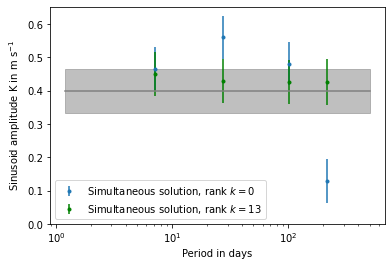

In [95]:
plt.errorbar(period,ampout_raw,yerr = amperrout_raw,fmt='.',label='Simultaneous solution, rank $k=0$')
plot([pmin,pmax],[ampcms/100,ampcms/100],'gray')
plt.errorbar(period,ampout,yerr = amperrout,fmt='.',color='green',label='Simultaneous solution, rank $k=%0.0i$'%kmax)
plt.fill_between((pmin,pmax),ampcms/100+np.mean(amperrout),ampcms/100-np.mean(amperrout),color='gray',alpha=0.5)
plt.legend()
plt.ylim(0,)
plt.xscale('log')
xlabel('Period in days')
ylabel('Sinusoid amplitude K in m s$^{-1}$')
savefig(savedir+'amp_simultfit.pdf')



In [96]:
jit = 0.0
KNew = []
powrNew = []
KerrNew = []
loglNew = []
data = rvorth
e = np.sqrt(rve**2 + jit**2)
e = vsymatNew
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t, d,e)
for f in farray:
    result = gls(t, d, e, f, W, Y)
    KNew.append(result[0])
    powrNew.append(result[1])
    KerrNew.append(result[2])
    loglNew.append(bglsfreq(t, d, rve, f, W, Y))
    
KModel = []
powrModel = []
KerrModel = []
loglModel = []
data = rvshape
e = np.sqrt(rve**2 + jit**2)
e = vsymatNew
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t,d,e)
for f in farray:
    result = gls(t, d, e, f, W, Y)
    KModel.append(result[0])
    powrModel.append(result[1])
    KerrModel.append(result[2])
    loglModel.append(bglsfreq(t, d, e, f, W, Y))

KShiftC = []
powrShift = []
KerrShift = []
loglShift = []
data = rvclean
e = np.sqrt(rve**2 + jit**2)
e = vsymatNew
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t, d,e)
for f in farray:
    result = gls(t, d, e, f, W, Y)
    KShiftC.append(result[0])
    powrShift.append(result[1])
    KerrShift.append(result[2])
    loglShift.append(bglsfreq(t, d, e, f, W, Y))
    
KOrbit = []
powrOrbit = []
KerrOrbit = []
loglOrbit = []
data = rvorbit
e = np.sqrt(rve**2 + jit**2)
e = vsymatNew
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t, d,e)
for f in farray:
    result = gls(t, d, e, f, W, Y)
    KOrbit.append(result[0])
    powrOrbit.append(result[1])
    KerrOrbit.append(result[2])
    loglOrbit.append(bglsfreq(t, d, e, f, W, Y))
    
KResid = []
powrResid = []
KerrResid = []
loglResid = []
data = rvresid
e = np.sqrt(rve**2 + jit**2)
e = vsymatNew
w = 1/e/e
unit = np.ones_like(w)
t = bjd - np.dot(w,bjd)/np.dot(w,unit)
d = data - np.dot(w,data)/np.dot(w,unit)
W, Y, YYh = bglsconst(t, d,e)
for f in farray:
    result = gls(t, d, e, f, W, Y)
    KResid.append(result[0])
    powrResid.append(result[1])
    KerrResid.append(result[2])
    loglResid.append(bglsfreq(t, d, e, f, W, Y))
    



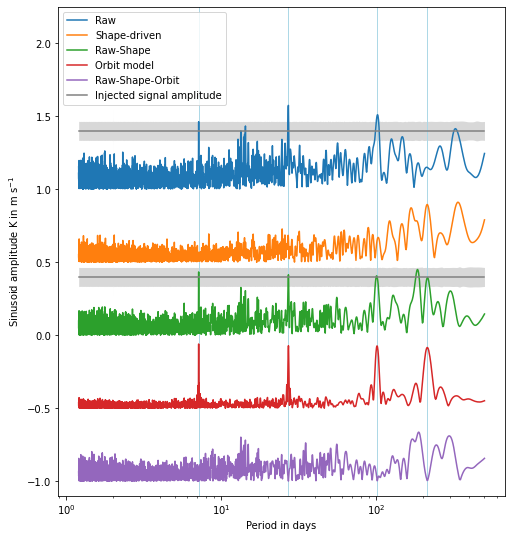

In [97]:
offset = 0.0005

plt.figure(figsize=(8,9))

for P in period:
    plt.axvline(P,linewidth=1,color='lightblue')


plt.semilogx(Parray,(np.array(KNew)+2*offset)*1000,label="Raw")
plt.semilogx(Parray,(np.array(KModel)+offset)*1000,label="Shape-driven")
plt.semilogx(Parray,(np.array(KShiftC)+0)*1000,label="Raw-Shape")
plt.semilogx(Parray,(np.array(KOrbit)-offset)*1000,label="Orbit model")
plt.semilogx(Parray,(np.array(KResid)-2*offset)*1000,label="Raw-Shape-Orbit")



up = (np.array(KShiftC)*0+ampcms/100000+np.array(KerrNew))*1000
dn = (np.array(KShiftC)*0+ampcms/100000-np.array(KerrNew))*1000
plt.fill_between(Parray,up+2*1000*offset,dn+2*1000*offset,color='gray',lw=0,alpha=0.3)
semilogx([pmin,pmax],[ampcms/100+2*1000*offset,ampcms/100+2*1000*offset],'gray',label='Injected signal amplitude')

up = (np.array(KShiftC)*0+ampcms/100000+np.array(KerrShift))*1000
dn = (np.array(KShiftC)*0+ampcms/100000-np.array(KerrShift))*1000
plt.fill_between(Parray,up,dn,color='gray',lw=0,alpha=0.3)
semilogx([pmin,pmax],[ampcms/100,ampcms/100],'gray')

#semilogx(Parray,(np.array(KNew)+2*offset)*1000,label='Observed')
#
#semilogx(Parray,(np.array(KModel)+offset)*1000,label='Shape-driven')
#
#semilogx(Parray,(np.array(KShiftC)+0)*1000,label='Shift-driven')

#plt.scatter(Parray,(np.array(KShift))*1000,s=1,c=bglsNew)
#plt.xscale('log')
xlabel('Period in days')
ylabel('Sinusoid amplitude K in m s$^{-1}$')
plt.legend(loc='upper left')
plt.ylim(-2200*offset,4500*offset)
savefig(savedir+'periodogram_scamp_%03icms.pdf'%ampcms,bbox_inches = 'tight')

show()
close()




In [98]:
array = find_extrema(farray,KShiftC,thresh=.00035)
for rec in array:   
    fpeaks = rec[0]
    ppeaks = 1/fpeaks
    amplitudes = rec[1]*1000
    #T0,K,Kerr,chs = sinefit(bjd, velmatShift, vsymatNew, periods)
    T0,K,Kerr,chs = sinefit(bjd, rvclean, vsymatNew, ppeaks)
    print('%6.5f & %6.3f & %5.3f& %5.3f'%(fpeaks,ppeaks,K*1000,Kerr*1000))

0.00466 & 214.369 & 0.395& 0.065
0.00541 & 184.748 & 0.451& 0.065
0.00994 & 100.627 & 0.408& 0.064
0.03687 & 27.125 & 0.415& 0.066
0.13998 &  7.144 & 0.434& 0.064


In [99]:
np.array([period,ampout,amperrout]).T

array([[7.14159000e+00, 4.50553672e-01, 6.51851457e-02],
       [2.71234500e+01, 4.30135520e-01, 6.56221779e-02],
       [1.01543210e+02, 4.26243548e-01, 6.59810739e-02],
       [2.13592650e+02, 4.27318944e-01, 6.85487487e-02]])

# Generate table 1 in LaTeX tabular format

In [100]:
col1 = period
col2 = period*0+ampcms/100
col6 = period
col7 = ampout
col8 = amperrout

In [101]:
col3 = []
col4 = []
col5 = []
avail = np.ones_like(np.array(pblind))

for p in period:
    idx = np.argsort(np.abs(np.array(pblind)-p)).astype(int)
    col3.append(np.asarray(pblind)[idx[0]])
    col4.append(np.asarray(kblind)[idx[0]])
    col5.append(np.asarray(kblerr)[idx[0]])
    avail[idx[0]] = 0
    
col3 = np.asarray(col3)
col4 = np.asarray(col4)
col5 = np.asarray(col5)

In [102]:
np.array(pblind)[avail.astype(bool)][0]

185.10074418176285

In [103]:
tab = np.array([col1,col2,col3,col4,col5,col6,col7,col8]).T


In [104]:
for i in range(len(tab)):
    rec = tuple(e for e in tab[i])
    print(' %7.3f & %5.3f & %7.3f & %5.3f & %5.3f & %7.3f & %5.3f & %5.3f \\\\'%rec)
    
rec = (np.array(pblind)[avail.astype(bool)][0],np.array(kblind)[avail.astype(bool)][0],np.array(kblerr)[avail.astype(bool)][0])
print(' -- & -- & %7.3f & %5.3f & %5.3f & -- & -- & -- \\\\ '%rec)

   7.142 & 0.400 &   7.144 & 0.443 & 0.064 &   7.142 & 0.451 & 0.065 \\
  27.123 & 0.400 &  27.133 & 0.426 & 0.066 &  27.123 & 0.430 & 0.066 \\
 101.543 & 0.400 & 100.625 & 0.448 & 0.064 & 101.543 & 0.426 & 0.066 \\
 213.593 & 0.400 & 215.219 & 0.395 & 0.065 & 213.593 & 0.427 & 0.069 \\
 -- & -- & 185.101 & 0.435 & 0.065 & -- & -- & -- \\ 


In [105]:
np.mean(col4),np.std(col4)/sqrt(len(col4))

(0.42801830468022084, 0.010389247280231368)

In [106]:
np.mean(col7),np.std(col7)/sqrt(len(col7))

(0.43356292080721737, 0.004956013784527597)

# End